In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
#from grids import *
from docking_analysis import *
import sklearn

/home/enf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [ ]:
from msm_resampled import *

In [ ]:
%matplotlib inline

In [ ]:
from detect_intermediates import *
from interpret_tICs import *

In [ ]:
from mor_h8_protein_ligand_feature_types import *
from get_variable_names import *
from mor_h8_protein_ligand_tica_config import *
from residue import Residue, Atom
from mor_h8_feature_types import feature_name_residues_dict


In [ ]:
#feature_name = "bp_residues_4dkl_5c1m_restricted_pairs"
rho = 0.01
rho_string = "_rho0pt01-normalized"

feature_name = "bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF"
#rho = 0.0025
#rho_string = "_rho0pt0025-normalized"

lag_time=50
n_clusters=1000
n_components=10

In [ ]:
feature_name

In [ ]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
tica_dir = "%s-aromatic-binarize-py3" %tica_dir
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


In [ ]:
all_ligand_features_dir = "%s-with-aromatic" %features_dir
if not os.path.exists(all_ligand_features_dir): os.makedirs(all_ligand_features_dir)

In [ ]:
ligand_residue = Residue(resSeq=1, chain_id="O", res_name="LIG")

In [ ]:
active_crystal = md.load_frame([t for t in get_trajectory_files(traj_dir, traj_ext) if "suf" in t][0], index=0)
ligand = [r for r in active_crystal.topology.residues if "LIG" in str(r)][0]
ligand_atom_names = [a.name for a in ligand.atoms if "H" not in a.name]
print(ligand_atom_names)

In [ ]:
#ligand_atom_names = ["N1", "O1", "C7", "C17", "O2", "N2", "C26"]
ligand_atoms = []
for atom_name in ligand_atom_names:
    ligand_atoms.append(Atom(resSeq=1, chain_id="O", atom_name=atom_name, res_name="LIG"))

In [ ]:
user_specified_atom_residue_pairs = sorted([x for x in itertools.product(ligand_atoms, bp_residue_objects)])
user_specified_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in user_specified_atom_residue_pairs]

In [ ]:
len(user_specified_atom_residue_pairs)

In [ ]:
protein_file = "/home/enf/md_simulations/MOR/suf_ref.h5"
refined_atom_residue_pairs = compute_atom_residue_pairs_under_cutoff(ligand_atoms, bp_residue_objects, protein_file, cutoff=1., all_lig_atoms=True)

In [ ]:
refined_atom_residue_pairs

In [ ]:
refined_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in refined_atom_residue_pairs]
print(len(refined_atom_residue_pairs))


In [ ]:
from ipyparallel import Client
rc = Client  ()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

In [18]:
aromatic_features_dir = "%s/suf_aromatic_features" %traj_dir
if not os.path.exists(aromatic_features_dir):
    os.makedirs(aromatic_features_dir)
aromatic_features_file = "%s/aromatic_features.dataset" %aromatic_features_dir
ring_dict = {}
suf_ring_dict = {}
suf_ring_dict["suf_ring1"] = [Atom(atom_name=n, res_name="LIG") for n in ["C22", "C17", "C13", "C18", "C23", "C25"]]
suf_ring_dict["suf_ring2"] = [Atom(atom_name=n, res_name="LIG") for n in ["C19", "S1", "C27", "C26", "C24"]]
ring_dict["tyr326_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=326) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["tyr148_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=148) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["tyr128_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=128) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["phe289_ring"] = [Atom(atom_name=n, res_name="PHE", resSeq=289) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["trp293_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=293) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp293_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=293) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["trp133_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=133) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp133_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=133) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["trp318_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=318) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp318_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=318) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["his297_ring"] = [Atom(atom_name=n, res_name="HIS", resSeq=297) for n in ["ND1", "CE1", "NE2", "CD2", "CG"]]
ring_dict["his319_ring"] = [Atom(atom_name=n, res_name="HIS", resSeq=319) for n in ["ND1", "CE1", "NE2", "CD2", "CG"]]

cation = Atom(atom_name="N4", res_name="LIG")

In [19]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *

import aromatic_featurizer
reload(aromatic_featurizer)
from aromatic_featurizer import *

NameError: name 'reload' is not defined

In [21]:
pi_pi_ring_pairs = [(ring_dict["trp293_ring1"], ring_dict["phe289_ring"]), (ring_dict["trp293_ring2"], ring_dict["phe289_ring"])]
#ring_pairs = []
for i, ring_i in enumerate(suf_ring_dict.values()):
    for j, ring_j in enumerate(ring_dict.values()):
        pi_pi_ring_pairs.append((ring_i, ring_j))
cation_pi_pairs = [(cation, ring) for ring in ring_dict.values()]

In [ ]:
suf_traj_files = [t for t in get_trajectory_files(traj_dir, traj_ext) if "suf" in t]

compute_aromatic_features_wrapper(traj_dir, traj_ext, None, pi_pi_ring_pairs, cation_pi_pairs,
    aromatic_features_file, aromatic_features_dir, worker_pool=dview, 
    parallel=False, traj_files=suf_traj_files)


In [22]:
aromatic_feature_objects = get_aromatic_feature_names(pi_pi_ring_pairs, cation_pi_pairs)
aromatic_names = [str(a) for a in aromatic_feature_objects]
aromatic_names

['TRP293-CD2 to PHE289-CG: Pi Parallel',
 'TRP293-CG to PHE289-CG: Pi Parallel',
 'LIG-C19 to TRP133-CG: Pi Parallel',
 'LIG-C19 to HIS319-ND1: Pi Parallel',
 'LIG-C19 to PHE289-CG: Pi Parallel',
 'LIG-C19 to TYR128-CG: Pi Parallel',
 'LIG-C19 to HIS297-ND1: Pi Parallel',
 'LIG-C19 to TRP133-CD2: Pi Parallel',
 'LIG-C19 to TRP318-CG: Pi Parallel',
 'LIG-C19 to TRP318-CD2: Pi Parallel',
 'LIG-C19 to TYR326-CG: Pi Parallel',
 'LIG-C19 to TYR148-CG: Pi Parallel',
 'LIG-C19 to TRP293-CD2: Pi Parallel',
 'LIG-C19 to TRP293-CG: Pi Parallel',
 'LIG-C22 to TRP133-CG: Pi Parallel',
 'LIG-C22 to HIS319-ND1: Pi Parallel',
 'LIG-C22 to PHE289-CG: Pi Parallel',
 'LIG-C22 to TYR128-CG: Pi Parallel',
 'LIG-C22 to HIS297-ND1: Pi Parallel',
 'LIG-C22 to TRP133-CD2: Pi Parallel',
 'LIG-C22 to TRP318-CG: Pi Parallel',
 'LIG-C22 to TRP318-CD2: Pi Parallel',
 'LIG-C22 to TYR326-CG: Pi Parallel',
 'LIG-C22 to TYR148-CG: Pi Parallel',
 'LIG-C22 to TRP293-CD2: Pi Parallel',
 'LIG-C22 to TRP293-CG: Pi Parallel

In [23]:
print("hi")

hi


In [48]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
import time
#time.sleep(60*120)
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = True, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs=user_specified_atom_residue_pairs, worker_pool=None, excluded_trajs=["apo", "oxy", "bu"], redo=False, binarize=None)

already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already feat

In [24]:
new_features_dir = "%s/reduced_features" %features_dir
if not os.path.exists(new_features_dir):
    os.makedirs(new_features_dir)
new_features_file = "%s/reduced_features.dataset" %new_features_dir
new_features_pkl = "%s/reduced_feature_names.pkl" %new_features_dir
retain_features_within_range(features_dir, compat_verboseload(feature_residues_pkl), 0.5,
                             0.01, new_features_file, new_features_pkl, worker_pool=None)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_114.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_148.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_162.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_129.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_1.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_191.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_177.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_205.dataset
lo

Process ForkPoolWorker-3:
Process ForkPoolWorker-12:
Process ForkPoolWorker-2:
Process ForkPoolWorker-11:
Process ForkPoolWorker-8:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/enf/anaconda3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/enf/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/enf/anaconda3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/enf/anaconda3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/enf/anaconda3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File 

In [25]:
new_feature_names = compat_verboseload(new_features_pkl)
feature_residues = new_feature_names
print(new_feature_names)
print(len(new_feature_names))

[Lig1-C10 to Asp147, Lig1-C10 to Gln124, Lig1-C10 to Ile144, Lig1-C10 to Ile322, Lig1-C10 to Lys233, Lig1-C10 to Lys303, Lig1-C10 to Trp318, Lig1-C10 to Tyr148, Lig1-C10 to Tyr299, Lig1-C10 to Val300, Lig1-C11 to Cys321, Lig1-C11 to Gln124, Lig1-C11 to Gly325, Lig1-C11 to Ile296, Lig1-C11 to Ile322, Lig1-C11 to Lys233, Lig1-C11 to Trp293, Lig1-C11 to Trp318, Lig1-C11 to Tyr148, Lig1-C11 to Tyr299, Lig1-C11 to Tyr326, Lig1-C11 to Val300, Lig1-C12 to Asp147, Lig1-C12 to Gln124, Lig1-C12 to Ile144, Lig1-C12 to Ile322, Lig1-C12 to Thr120, Lig1-C12 to Trp133, Lig1-C12 to Trp318, Lig1-C12 to Tyr128, Lig1-C12 to Tyr148, Lig1-C12 to Tyr326, Lig1-C12 to Val143, Lig1-C13 to Ala117, Lig1-C13 to Asp147, Lig1-C13 to Gly325, Lig1-C13 to His297, Lig1-C13 to Ile296, Lig1-C13 to Ile322, Lig1-C13 to Met151, Lig1-C13 to Trp293, Lig1-C13 to Tyr148, Lig1-C13 to Tyr326, Lig1-C13 to Val236, Lig1-C13 to Val300, Lig1-C14 to Asp147, Lig1-C14 to Gly325, Lig1-C14 to His297, Lig1-C14 to Ile296, Lig1-C14 to Ile322,

In [26]:
ori_feature_names = compat_verboseload(feature_residues_pkl)

In [27]:
pool = mp.Pool(mp.cpu_count())
all_features_np = np.concatenate(pool.map(load_file,get_trajectory_files(features_dir, ".dataset")))
pool.terminate()

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_114.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_162.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_177.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_205.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_1.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_148.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_129.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/suf__rep_191.dataset
lo

In [27]:
all_features_df = pd.DataFrame(all_features_np, columns=[str(n) for n in ori_feature_names])

NameError: name 'all_features_np' is not defined

In [28]:
with open(new_features_pkl, "rb") as f:
    feature_residues = pickle.load(f)
all_ligand_features_pkl = "%s/feature_names.pkl" %all_ligand_features_dir
all_ligand_feature_names = feature_residues + aromatic_names #[n for n in aromatic_names if "lig" in str(n).lower()]
all_ligand_feature_objects = feature_residues + aromatic_feature_objects #[n for n in aromatic_feature_objects if "lig" in str(n).lower()]
with open(all_ligand_features_pkl, "wb") as f:
    pickle.dump(all_ligand_feature_objects, f)
print(all_ligand_feature_objects)

[Lig1-C10 to Asp147, Lig1-C10 to Gln124, Lig1-C10 to Ile144, Lig1-C10 to Ile322, Lig1-C10 to Lys233, Lig1-C10 to Lys303, Lig1-C10 to Trp318, Lig1-C10 to Tyr148, Lig1-C10 to Tyr299, Lig1-C10 to Val300, Lig1-C11 to Cys321, Lig1-C11 to Gln124, Lig1-C11 to Gly325, Lig1-C11 to Ile296, Lig1-C11 to Ile322, Lig1-C11 to Lys233, Lig1-C11 to Trp293, Lig1-C11 to Trp318, Lig1-C11 to Tyr148, Lig1-C11 to Tyr299, Lig1-C11 to Tyr326, Lig1-C11 to Val300, Lig1-C12 to Asp147, Lig1-C12 to Gln124, Lig1-C12 to Ile144, Lig1-C12 to Ile322, Lig1-C12 to Thr120, Lig1-C12 to Trp133, Lig1-C12 to Trp318, Lig1-C12 to Tyr128, Lig1-C12 to Tyr148, Lig1-C12 to Tyr326, Lig1-C12 to Val143, Lig1-C13 to Ala117, Lig1-C13 to Asp147, Lig1-C13 to Gly325, Lig1-C13 to His297, Lig1-C13 to Ile296, Lig1-C13 to Ile322, Lig1-C13 to Met151, Lig1-C13 to Trp293, Lig1-C13 to Tyr148, Lig1-C13 to Tyr326, Lig1-C13 to Val236, Lig1-C13 to Val300, Lig1-C14 to Asp147, Lig1-C14 to Gly325, Lig1-C14 to His297, Lig1-C14 to Ile296, Lig1-C14 to Ile322,

In [29]:
all_contact_features = load_file(new_features_file)
all_contact_features = [sklearn.preprocessing.binarize(f, 0.5) for f in all_contact_features]
aromatic_features = load_file(aromatic_features_file)
indices = [i for i in range(0,len(aromatic_names)) if "lig" in str(aromatic_names[i]).lower()]
print(indices)
#all_ligand_features = [np.hstack([all_contact_features[i], aromatic_features[i][:,indices]]) for i in range(0,len(all_contact_features))]
all_ligand_features = [np.hstack([all_contact_features[i], aromatic_features[i]]) for i in range(0,len(all_contact_features))]

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/reduced_features/reduced_features.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/suf_aromatic_features/aromatic_features.dataset
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


In [40]:
#os.system("rm -rf %s" % tica_dir)
#lag_time = 5
#n_components = 5
#sparse = True
#wolf = True
#rho = 0.0025
#shrinkage = None
#traj_ext = ".h5"
#import custom_tica
#reload(custom_tica)
#from custom_tica import *
#fit_normalizer(features_dir, features=load_file(new_features_file))
#fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))
#fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=False, partial_fit=False, features=all_ligand_features)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/reduced_features/reduced_features.dataset
Saving "/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/normalizer.h5"... (<class 'sklearn.preprocessing.data.StandardScaler'>)
loading "/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/normalizer.h5"...
loading feature files
(484, 437)
[ 0.  1.  0.  1.  1.  1.  1.  0.  1.  1.]
(754,)
fitting data to tICA model
transformed data with tICA model
Sparse time-structure based Independent Components Analysis (tICA)
------------------------------------------------------------------
n_components        : 10
shrinkage           : 0.00013456644161877041
lag_time            : 50
weighted_transform  : False
rho                 : 0.01
n_features          : 437

Top 5 timescales :
[ 515.93989827  327.58078377  276.47562054  233.589608    210.46394913]

Top 5 eige

In [30]:
tica_object = verboseload(projection_operator_dir)
tica_object.timescales_

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/phi_psi_chi2_allprot_tica_coords.h5"...


array([ 515.93989827,  327.58078377,  276.47562054,  233.589608  ,
        210.46394913,  198.78522811,  171.47962917,  162.91166301,
        154.21311352,  144.13468294])

In [31]:
#import interpret_tICs
#reload(interpret_tICs)
#from interpret_tICs import *
tic_components_dir = tica_dir
#important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, new_features_pkl, n_tica_components=n_components, percentile=95)
important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, all_ligand_features_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(21, 5)
residue_importances_df.shape
(25, 2)
                    feature_name      res_i      res_j  importance  \
3             Lig1-C20 To Trp293   Lig1-C20     Trp293   -0.707351   
18             Lig1-O3 To Tyr299    Lig1-O3     Tyr299    0.407946   
1             Lig1-C20 To Cys321   Lig1-C20     Cys321    0.397416   
5             Lig1-C20 To Tyr299   Lig1-C20     Tyr299    0.364832   
15             Lig1-C8 To Val300    Lig1-C8     Val300    0.334571   
17             Lig1-O2 To Tyr299    Lig1-O2     Tyr299    0.325392   
6             Lig1-C22 To Ile322   Lig1-C22     Ile322   -0.277202   
16             Lig1-C9 To Ala117    Lig1-C9     Ala117    0.275897   
14             Lig1-C7 To Thr120    Lig1-C7     Thr120    0.243362   
7             Lig1-C22 To Ser329   Lig1-C22     Ser329    0.240427   
4             Lig1-C20 To Trp318   Lig1-C20     Trp318   -0.216052   
11            Lig1-C25 To Asp114   Lig1-C25     Asp114    0.206774 

/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/interpret_tICs.py:98: FutureWarning: order is deprecated, use sort_values(...)
  df = df.reindex(df_copy.importance.abs().order(ascending=False).index)


             residue  importance
Tyr299        Tyr299    0.403634
Cys321        Cys321    0.397416
Lig1-O3      Lig1-O3    0.395715
Lig1-C20    Lig1-C20    0.390899
Lig1-C8      Lig1-C8    0.334571
Val300        Val300    0.326009
Lig1-O2      Lig1-O2    0.325392
Ile322        Ile322   -0.277202
Lig1-C9      Lig1-C9    0.275897
Ala117        Ala117    0.270179
Thr120        Thr120    0.243362
Lig1-C7      Lig1-C7    0.243362
Ser329        Ser329    0.240427
Trp318        Trp318   -0.216052
Asp114        Asp114    0.206774
Lig1-C22    Lig1-C22    0.200865
Lig1-C11    Lig1-C11    0.194875
Gly325        Gly325    0.194299
Trp293        Trp293   -0.174708
Lig1-C25    Lig1-C25    0.171429
Asn150        Asn150    0.161553
Lig1-C23    Lig1-C23    0.161551
Tyr326        Tyr326   -0.156742
Trp293-Cg  Trp293-Cg    0.096202
Phe289-Cg  Phe289-Cg    0.096202
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(22, 5)
residue_importances_df.shape
(26, 2)
                         fe

In [32]:
tic_subsampled_features_file= "%s/features_subsampled.pkl" % tica_dir



In [35]:
print(tic_subsampled_features_file)
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features, feature_residues)
#subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file, features=load_file(new_features_file))

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/features_subsampled.pkl


TypeError: 'AromaticFeature' object is not iterable

In [36]:
tica_coords = verboseload(projected_features_dir)
print(np.shape(np.concatenate(tica_coords)))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/phi_psi_chi2_allprot_projected.h5"...
(272021, 10)


In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_columns(tica_dir, projected_features_dir, titles = ["suf_tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [37]:
suf_trajs = []
apo_trajs = []
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "oxy" not in t]
trajs = [t for t in get_trajectory_files(traj_dir, traj_ext)]
for i, traj in enumerate(trajs):
    if "suf" in traj:
        suf_trajs.append(i)
    elif "apo" in traj:
        apo_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5


In [38]:
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025"
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup"
pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup"

In [39]:
protein_tica_file = "%s/phi_psi_chi2_allprot_projected.h5" %pp_tica_dir
protein_tica = verboseload(protein_tica_file)
protein_tica_suf = [protein_tica[i] for i in suf_trajs]

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/phi_psi_chi2_allprot_projected.h5"...


In [40]:
protein_tica_suf_conc = np.concatenate(protein_tica_suf)
ligand_tica_suf_conc =  np.concatenate(verboseload(projected_features_dir))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/phi_psi_chi2_allprot_projected.h5"...


In [ ]:
import plots
reload(plots)
from plots import *

#plot_data_vs_data(protein_tica_suf_conc, ligand_tica_suf_conc, ["mOR_tIC%d" %i for i in range(1,n_components+1)], ["suf_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [ ]:
n_clusters = 1000
clusterer_dir = "%s/sufclusterer_%dclusters.h5" % (tica_dir, n_clusters)
cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters, clusterer_dir)

In [ ]:
import custom_msm
reload(custom_msm)
from custom_msm import *
plot_timescales(clusterer_dir, n_clusters, tica_dir, main="", lag_times=list(range(1,51,10)))

In [ ]:
lag_time = 30
msm_model_dir = "%s/msm_lag_time%d.h5" % (tica_dir, lag_time)
if not os.path.exists(msm_model_dir):
    build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)
suf_msm = verboseload(msm_model_dir)

In [ ]:
'%s/suf_clusterer1000.h5' %pp_tica_dir

In [199]:
pp_msm_lag_time=25
pp_n_clusters = 1000
prior_counts=1e-5
suf_pp_resampled_traj_to_frames_file = "%s/suf_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
suf_pp_resampled_traj_to_frames = verboseload(suf_pp_resampled_traj_to_frames_file)
suf_pp_msm_file = "%s/suf_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
suf_pp_msm = verboseload(suf_pp_msm_file)
suf_pp_clusterer = verboseload('%s/suf_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters))
suf_pp_clusters_map = make_clusters_map(suf_pp_clusterer)
suf_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
suf_pp_tic_components_dir = "%s" %pp_tica_dir
suf_pp_tica_dir = suf_pp_tic_components_dir
suf_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/feature_residues.pkl"
pp_tic_subsampled_features = '/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl'
#pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
suf_pp_tica = verboseload("%s/suf_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters))
suf_pp_pnas_file = "%s/suf_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
suf_pp_pnas = verboseload(suf_pp_pnas_file)
suf_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
suf_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_msm_lag-time25_prior-counts1e-05_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer1000.h5"...
517
31
267
95
508
0
7
1167
0
651
1
20
0
11
1516
0
909
33
144
1490
277
2
0
559
5
1171
183
37
1334
742
45
11
1047
605
0
19
51
3
0
10
83
538
188
181
1335
4
283
951
0
0
1024
0
257
40
29
337
4
1394
0
131
143
0
324
120
108
43
177
1
480
974
703
7
0
81
0
345
258
23
687
0
34
454
345
1
755
1103
14
0
965
222
11
10
0
70
678
208
30

In [200]:
pp_msm_lag_time=25
pp_n_clusters = 1000
prior_counts = 1e-5
apo_pp_resampled_traj_to_frames_file = "%s/apo_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
apo_pp_resampled_traj_to_frames = verboseload(apo_pp_resampled_traj_to_frames_file)
apo_pp_msm_file = "%s/apo_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
apo_pp_msm = verboseload(apo_pp_msm_file)
apo_pp_clusterer = verboseload('%s/apo_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters))
apo_pp_clusters_map = make_clusters_map(apo_pp_clusterer)
apo_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
apo_pp_tica_file = "%s/apo_tica.h5" %pp_tica_dir
apo_pp_clusterer_file = '%s/apo_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters)
apo_pp_tic_components_dir = "%s" %pp_tica_dir
apo_pp_tica_dir = apo_pp_tic_components_dir
apo_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/feature_residues.pkl"
apo_pp_tica = verboseload("%s/apo_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters))
apo_pp_pnas_file = "%s/apo_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
apo_pp_pnas = verboseload(apo_pp_pnas_file)
apo_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
apo_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_msm_lag-time25_prior-counts1e-05_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_clusterer1000.h5"...
0
154
0
0
0
0
559
2
0
0
58
129
818
414
0
777
0
1037
791
0
534
459
201
0
695
204
505
129
101
3
553
288
0
6
638
995
1
541
0
239
713
189
0
0
12
264
6
0
0
161
0
0
0
151
633
0
0
0
235
732
213
0
2
234
102
582
696
2
0
0
6
235
240
137
304
0
942
759
8
6
447
0
0
960
0
0
1255
3
0
1
1
336
0
986
23
434
0
1
154
0
1176
0
0
14
115
710

In [201]:
pp_analysis_dir = "%s-%sclusters_%dlag-time" %(analysis_dir, pp_n_clusters,pp_msm_lag_time)
analysis_dir = pp_analysis_dir
if not os.path.exists(analysis_dir):
    os.makedirs(analysis_dir)

In [202]:
pp_n_components=10
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/feature_residues.pkl"
pp_feature_residues = load_file(pp_feature_residues_pkl)
lp_feature_residues = load_file(new_features_pkl)

ref_pp_features = pd.DataFrame(get_features(suf_pp_ref_features_dir), columns=[str(f) for f in pp_feature_residues])
#ref_lp_features = pd.DataFrame(get_features(ref_features_dir), columns=[str(f) for f in lp_feature_residues])
ref_pp_tica = pd.read_csv(suf_pp_ref_tica, header=None)
ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]

#ref_lp_tica = pd.read_csv(ref_tica_coords, header=None)
#ref_lp_tica.columns=["suf tIC.%d" %i for i in range(1,n_components+1)]

ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

ref_features = pd.concat([ref_pp_features*10., ref_pp_tica, ref_pnas], axis=1)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/feature_residues.pkl
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/reduced_features/reduced_feature_names.pkl
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/4dkl_R_for_conformation.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/5c1m.dataset
(2, 2408)


OSError: File b'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/reference_receptors/refcoords.csv' does not exist

In [203]:
tica_coords = verboseload(projected_features_dir)
suf_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5"
apo_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"
suf_pnas = verboseload(suf_pnas_file)
apo_pnas = verboseload(apo_pnas_file)
suf_tica_file = '%s/suf_tica.h5' %pp_tica_dir
apo_tica_file = "%s/apo_tica.h5" %pp_tica_dir
suf_tica = verboseload(suf_tica_file)
apo_tica = verboseload(apo_tica_file)

suf_aromatic = load_file(aromatic_features_file)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_tica.h5"...
loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/suf_aromatic_features/aromatic_features.dataset


In [204]:
len(suf_aromatic)

754

In [205]:
len(aromatic_names)

64

In [206]:
pp_n_components = 10
suf_pnas_dfs = []
for array in suf_pnas:
    suf_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
suf_tica_dfs = []
for array in suf_tica:
    suf_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
lp_tica_dfs = []
for array in tica_coords:
    lp_tica_dfs.append(pd.DataFrame(array, columns=["suf tIC.%d" %i for i in range(1,n_components+1)]))
suf_feature_dfs = []
suf_features = load_file(new_features_file)
print("loaded suf features")
for array in suf_features:
    suf_feature_dfs.append(pd.DataFrame(array*10., columns=[str(f) for f in new_feature_names]))

suf_pi_dfs = []
for array in suf_aromatic:
    suf_pi_dfs.append(pd.DataFrame(array, columns=aromatic_names))
new_suf_feature_dfs = []
for i in range(0, len(suf_pi_dfs)):
    new_suf_feature_dfs.append(pd.concat([suf_pi_dfs[i], suf_feature_dfs[i]], axis=1))
suf_feature_dfs = new_suf_feature_dfs
    
apo_pnas_dfs = []
for array in apo_pnas:
    apo_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
apo_tica_dfs = []
for array in apo_tica:
    apo_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["apo tIC.%d" %i for i in range(1,n_components+1)]))



loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/reduced_features/reduced_features.dataset
loaded suf features


In [207]:
suf_pnas = verboseload("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5")
cluster_pnas_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, suf_pnas)
cluster_pnas_averages = pd.DataFrame(cluster_pnas_averages, columns=sorted(feature_name_residues_dict.keys()))
active_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_active"] > 0.2) & (cluster_pnas_averages["rmsd_npxxy_active"] < 0.25) & (cluster_pnas_averages["tm6_tm3_packing"] > 12.75) & (cluster_pnas_averages["tm6_tm3_packing"] < 13.25)]
inactive_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_inactive"] < 0.4) & (cluster_pnas_averages["rmsd_npxxy_inactive"] > 0.3) & (cluster_pnas_averages["tm6_tm3_packing"] > 8.0) & (cluster_pnas_averages["tm6_tm3_packing"] < 9.5)]
print(active_clusters.index.values)
print(inactive_clusters.index.values)



loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5"...


/home/enf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


[  7  13  18  25  27  28  30  32  33  41  42  44  53  73  76  78  82 102
 104 113 122 125 126 127 129 139 147 148 153 176 180 183 193 216 223 230
 234 235 241 245 247 249 255 256 263 269 271 277 279 285 286 291 295 300
 308 312 324 327 329 332 346 347 355 357 366 371 373 375 383 401 411 414
 420 424 425 428 430 434 439 444 447 450 456 467 470 472 473 476 487 488
 490 492 494 499 503 515 517 527 534 535 539 540 543 544 545 550 552 576
 578 580 591 592 594 595 598 611 612 615 616 618 623 641 648 655 660 661
 671 677 680 688 693 699 703 711 717 734 735 741 743 744 746 747 751 752
 757 761 762 775 786 794 796 801 805 807 809 824 832 834 836 838 844 846
 849 852 858 867 869 870 873 875 888 889 892 893 896 906 919 925 926 927
 938 940 943 947 949 954 955 956 959 961 963 964 982 985 991 993]
[178 500]


In [208]:
cluster_tica_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, suf_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, pp_n_components+1)])
cluster_tica_pnas = pd.concat([cluster_pnas_averages, cluster_tica_averages], axis=1).dropna()
#set(cluster_tica_averages.loc[cluster_tica_averages["tIC.4"] > 0.].index.values.tolist()).intersection(set(active_clusters.index.values.tolist()))
#cluster_tica_pnas.loc[cluster_tica_pnas["tIC.5"] > 5.]

/home/enf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [209]:
intermediate_actives = cluster_tica_averages.loc[(cluster_tica_averages["tIC.2"] > 0.7) & (cluster_tica_averages["tIC.2"] < 1.2) & (cluster_tica_averages["tIC.5"] > 0.) & (cluster_tica_averages["tIC.2"] > 0.8)].index.values
msm_intermediate_actives = suf_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(suf_pp_msm.populations_[msm_intermediate_actives])
print(suf_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])


[  4.26860702e-06   7.43002142e-06   1.28640466e-05   1.39061938e-05
   8.53272977e-05   9.15525649e-05   9.61656385e-05   1.01856511e-04
   1.18407963e-04   1.21444015e-04   1.66304976e-04   3.10416506e-04
   3.55464906e-04   8.41548541e-04   9.62945661e-04   9.64564169e-04
   1.00926941e-03   1.21861297e-03   1.32988230e-03   1.33718435e-03
   2.76826658e-03   6.12451966e-03]
[ 46  54  68 135 340 352 372 390 446 479 482 593 628 644 645 662 676 708
 753 776 781 789]
[482 446 708 593 628 781 753 776 372  54 676 644 352 340 662 789 479 645
  46  68 135 390]


In [210]:
#ligand_top_features = load_file(tic_subsampled_features_file)
protein_top_features = load_file(pp_tic_subsampled_features)
protein_top_features_apo = [protein_top_features[i]*10. for i in apo_trajs]
protein_top_features_suf = [protein_top_features[i]*10. for i in suf_trajs]



loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl


In [211]:
#import interpret_tICs
#reload(interpret_tICs)
#from interpret_tICs import *
suf_pp_all_features, suf_pp_tIC_features = interpret_tIC_components(suf_pp_projection_operator_dir, suf_pp_tic_components_dir, suf_pp_feature_residues_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(10, 5)
residue_importances_df.shape
(12, 2)


/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/interpret_tICs.py:98: FutureWarning: order is deprecated, use sort_values(...)
  df = df.reindex(df_copy.importance.abs().order(ascending=False).index)


             feature_name      res_i      res_j  importance  \
7  Lys233_Ca To Lys303_Ca  Lys233_Ca  Lys303_Ca   -0.380112   
1  Ala304_Ca To Asn230_Ca  Ala304_Ca  Asn230_Ca    0.325877   
2  Ala304_Ca To Lys233_Ca  Ala304_Ca  Lys233_Ca    0.306402   
6  Ile308_Ca To Tyr299_Ca  Ile308_Ca  Tyr299_Ca    0.290794   
5  Ile308_Ca To Trp318_Ca  Ile308_Ca  Trp318_Ca   -0.284625   
3  Ala304_Ca To Tyr299_Ca  Ala304_Ca  Tyr299_Ca   -0.282444   
0        Leu339 To Val334     Leu339     Val334    0.251023   
9  Val236_Ca To Val300_Ca  Val236_Ca  Val300_Ca    0.222654   
4  Ile301_Ca To Val236_Ca  Ile301_Ca  Val236_Ca   -0.214483   
8  Lys303_Ca To Trp318_Ca  Lys303_Ca  Trp318_Ca    0.171570   

                  feature  
7  LYS233_CA to LYS303_CA  
1  ALA304_CA to ASN230_CA  
2  ALA304_CA to LYS233_CA  
6  ILE308_CA to TYR299_CA  
5  ILE308_CA to TRP318_CA  
3  ALA304_CA to TYR299_CA  
0        LEU339 to VAL334  
9  VAL236_CA to VAL300_CA  
4  ILE301_CA to VAL236_CA  
8  LYS303_CA to TRP318_CA 

In [136]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
sources = [suf_pp_msm.mapping_[i] for i in active_clusters.index.values if i in suf_pp_msm.mapping_.keys()]
sinks = [suf_pp_msm.mapping_[i] for i in inactive_clusters.index.values if i in suf_pp_msm.mapping_.keys()]
print(sources)
print(sinks)
suf_pp_tpt_paths_file = "%s/suf_clusterer1000_tpt_paths.h5" %pp_tica_dir
tpt_paths, inv_tpt_paths, _ = generate_tpt_traj_index_series(suf_pp_msm, sources=sources, sinks=sinks, clusters_map=suf_pp_clusters_map, num_paths=10, remove_path = 'subtract', save_file=suf_pp_tpt_paths_file)

[1, 3, 10, 13, 17, 23, 28, 30, 35, 36, 47, 52, 57, 69, 74, 100, 101, 102, 106, 109, 114, 121, 132, 138, 139, 144, 145, 157, 162, 167, 173, 180, 198, 202, 218, 223, 228, 230, 236, 237, 243, 248, 253, 257, 260, 262, 265, 266, 268, 270, 281, 283, 290, 298, 301, 317, 321, 324, 327, 330, 333, 340, 347, 356, 365, 379, 380, 381, 386, 395, 396, 399, 401, 402, 404, 406, 419, 426, 432, 447, 458, 460, 469, 481, 490, 491, 492, 493, 494, 502, 512, 514, 520, 522, 531, 533, 534, 537, 538, 546, 549, 558, 564, 566, 567, 572, 575, 579, 583, 591, 600, 610, 618, 619, 620, 625, 626, 637, 638, 641, 648, 654, 660, 671, 673, 683, 684, 694, 712, 714, 715, 725, 727, 734, 735, 736, 742, 750, 761, 764, 768, 771, 772, 798, 799, 800, 803, 808, 814, 820, 821, 826, 837, 839, 845, 848, 850, 873, 876, 880, 882, 886, 888, 897, 900, 905, 910, 915, 921, 925, 927, 932, 936, 940, 947, 954, 955, 961, 963, 966, 968, 980, 985, 988, 989, 990, 995, 1005, 1014, 1024, 1039, 1040, 1051, 1056, 1059, 1060, 1064, 1073, 1078, 1080, 108

In [ ]:
tm6_out_clusters = cluster_pnas_averages.loc[cluster_pnas_averages["tm6_tm3_packing"] > 12.75].index.values
sources = [suf_pp_msm.mapping_[i] for i in tm6_out_clusters if i in suf_pp_msm.mapping_.keys()]
sinks = copy.deepcopy(sources)
suf_pp_tpt_paths_file = "%s/suf_clusterer1000_tm6_out_tpt_paths.h5" %pp_tica_dir
tm6_tpt_paths, tm6_inv_tpt_paths, _ = generate_tpt_traj_index_series(suf_pp_msm, sources=sources, sinks=sinks, clusters_map=suf_pp_clusters_map, num_paths=5, remove_path = 'subtract', save_file=suf_pp_tpt_paths_file)

In [ ]:
sources

In [ ]:
inv_tpt_paths

In [53]:
#lig_features = list(set([str(g) for l in all_tIC_features for g in l]))
#prot_features = list(set([str(g) for l in suf_pp_tIC_features for g in l]))
#f0 = pd.concat([f*10. for f in ligand_top_features], axis=0)
#f0 = pd.concat([f*10. for f in ligand_top_features], axis=0)
#f1 = pd.concat([f*10. for f in protein_top_features_suf], axis=0)
#f2 = pd.concat([f for f in suf_tica_dfs])
#f3 = pd.concat([f for f in suf_pnas_dfs])
#prot_lig_features = pd.concat([f0,f1,f2,f3],axis=1)
all_traj_features = [pd.concat([suf_feature_dfs[i], protein_top_features_suf[i], suf_tica_dfs[i], suf_pnas_dfs[i]], axis=1) for i in range(0, len(suf_tica_dfs))]

/home/enf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [213]:
inactive_clusters = cluster_features_averages.loc[cluster_features_averages["ASN150 to PHE289"] < 7.5]
active_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_active"] > 0.2) & (cluster_pnas_averages["rmsd_npxxy_active"] < 0.25) & (cluster_pnas_averages["tm6_tm3_packing"] > 12.75) & (cluster_pnas_averages["tm6_tm3_packing"] < 13.25)]



In [214]:
inactive_clusters["rmsd_npxxy_inactive"]

46     0.253178
165    0.250022
178    0.309909
179    0.253128
335    0.255941
413    0.757316
500    0.343548
501    0.246574
965    0.239131
Name: rmsd_npxxy_inactive, dtype: float64

(array([  2.00000000e+00,   0.00000000e+00,   3.70000000e+01,
          2.45000000e+02,   2.92100000e+03,   1.54860000e+04,
          2.83000000e+04,   3.01590000e+04,   2.68100000e+04,
          2.29550000e+04,   1.97420000e+04,   1.73420000e+04,
          1.48580000e+04,   1.31880000e+04,   1.21220000e+04,
          1.17010000e+04,   1.07660000e+04,   9.82200000e+03,
          8.70700000e+03,   7.34000000e+03,   5.91700000e+03,
          4.31700000e+03,   3.09700000e+03,   2.05500000e+03,
          1.31500000e+03,   8.11000000e+02,   5.41000000e+02,
          3.37000000e+02,   2.18000000e+02,   1.80000000e+02,
          1.56000000e+02,   1.12000000e+02,   1.12000000e+02,
          8.90000000e+01,   6.30000000e+01,   5.30000000e+01,
          4.40000000e+01,   2.30000000e+01,   1.90000000e+01,
          1.00000000e+01,   1.00000000e+01,   9.00000000e+00,
          1.20000000e+01,   6.00000000e+00,   3.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   1.00000000e+00,
        

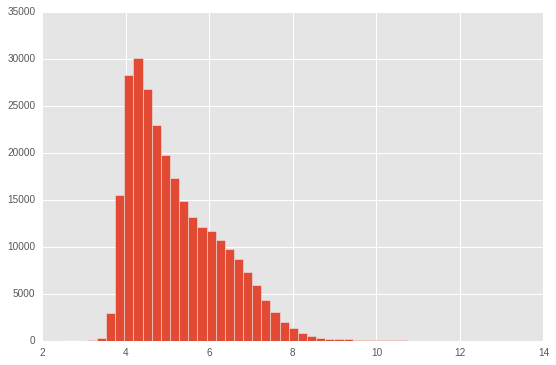

In [215]:
plt.hist(pd.concat(all_traj_features, axis=0)["Lig1-N4 to Gln124"], bins=50)

In [232]:
from imp import reload
import msm_resampled
reload(msm_resampled)
from msm_resampled import *

def find_good_msm(msm_object, clusters_map, start_clusters, target_clusters, n_steps, save_file=None):
    redo = True
    while redo:
        msm_traj_index_pairs, cluster_list = generate_msm_traj_index_series(msm_object, random.choice(start_clusters), n_steps, clusters_map, None)
        n_appearances = 0
        for cluster in target_clusters:
            n_appearances += len([c for c in cluster_list if c==cluster])
        if float(n_appearances) / float(n_steps) > 0.02:
            redo = False
        else:
            print(float(n_appearances) / float(n_steps))
    return msm_traj_index_pairs

msm_traj_index_pairs = find_good_msm(suf_pp_msm, suf_pp_clusters_map, active_clusters.index.values.tolist(), inactive_clusters.index.values.tolist(), 10000)

0.0142
0.0084
0.0197
0.0023
0.0086
0.0116
0.0013
0.0083
0.0088
0.0048
0.0
0.0042
0.0016


In [233]:

#n_steps = 100000
#save_file = "%s/msm%d_clusters_t25%d_lagtime%d_steps_2_inactive.h5" % (suf_pp_tica_dir, pp_n_clusters, pp_msm_lag_time, n_steps)
#if 1==1:
#if not os.path.exists(save_file):
#    msm_traj_index_pairs = generate_msm_traj_index_series(suf_pp_msm, random.choice(active_clusters.index.values.tolist()), n_steps, suf_pp_clusters_map, save_file)
#else:
#    msm_traj_index_pairs = verboseload(save_file)
protein_ligand_msm_featurized = resample_features_by_msm_trajectory(all_traj_features, msm_traj_index_pairs)

/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/detect_intermediates.py:486: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=True,window=5).mean()
  pd.rolling_mean(df, smoothing, center=True, min_periods=None)[var].plot(ax=axes[i], linewidth=2.5, title=var, c=c)


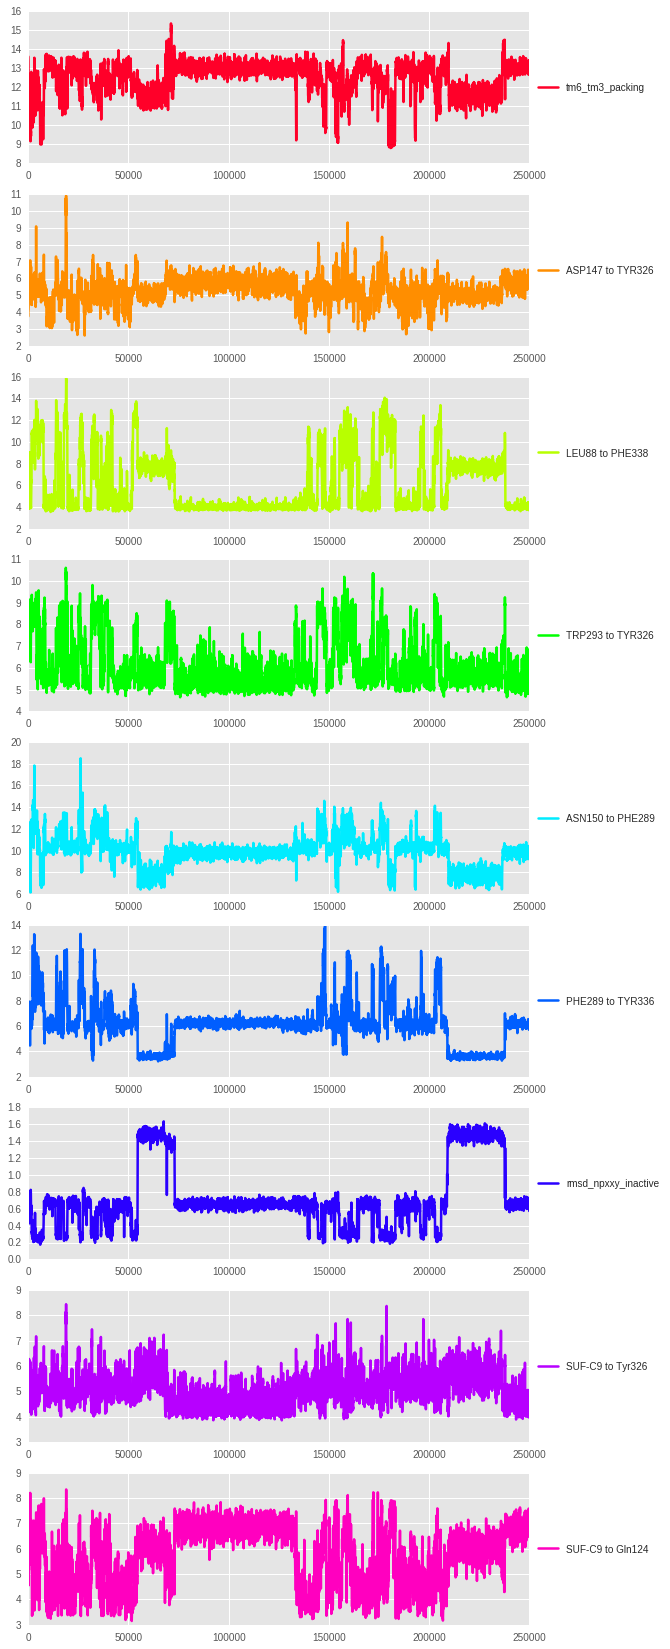

In [234]:
plmf = copy.deepcopy(protein_ligand_msm_featurized)
smoothing=5
names = plmf.columns.values.tolist()
for i, name in enumerate(names):
    if "LIG" in str(name):
        names[i] = "SUF" + name[3:]
    if "Lig1" in str(name):
        names[i] = "SUF" + name[4:]
plmf.columns = names
plmf.index = plmf.index.values * 25
plot_features = plmf[["tm6_tm3_packing", "ASP147 to TYR326", "LEU88 to PHE338", "TRP293 to TYR326", "ASN150 to PHE289", "PHE289 to TYR336", "rmsd_npxxy_inactive", "SUF-C9 to Tyr326", "SUF-C9 to Gln124"]]
#plot_features = plmf[["tm6_tm3_packing", "ASN150 to PHE289", "TRP293 to ALA240", "ASN332_CA to TRP293_CA", "TYR336 to ASP114", "SUF-C9 to Tyr326", "SUF-C9 to Gln124", "SUF-O3 to Val300", "SUF-C20 to Ile322","SUF-C19 to TRP133-CD2: Pi T", "SUF-C22 to TRP293-CD2: Pi T"]]# "SUF-C19 to Trp133", "SUF-C22 to Tyr326"]]
plot_file = "%s/key_measurements_tIC5_4_smoothing%d.png" %(analysis_dir, smoothing)
plot_df_rolling(plot_features.iloc[:100000], plot_file, True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)
plt.show()

In [ ]:
all_traj_features_conc = pd.concat(all_traj_features, axis=0)

(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.10000000e+01,   4.14000000e+02,   1.91200000e+03,
          3.00500000e+03,   2.41700000e+03,   1.90700000e+03,
          1.64600000e+03,   1.72700000e+03,   2.24800000e+03,
          3.12200000e+03,   4.79700000e+03,   9.14100000e+03,
          1.79100000e+04,   2.65490000e+04,   2.64240000e+04,
          1.90540000e+04,   1.15040000e+04,   6.44600000e+03,
          3.81200000e+03,   2.56700000e+03,   1.93200000e+03,
          1.61000000e+03,   1.26800000e+03,   1.08900000e+03,
          9.49000000e+02,   9.36000000e+02,   9.09000000e+02,
          8.76000000e+02,   8.32000000e+02,   7.21000000e+02,
          5.59000000e+02,   4.90000000e+02,   4.16000000e+02,
          4.13000000e+02,   3.50000000e+02,   2.89000000e+02,
          2.30000000e+02,   1.72000000e+02,   1.83000000e+02,
          1.46000000e+02,   1.36000000e+02,   1.00000000e+02,
          8.70000000e+01,   7.50000000e+01,   3.50000000e+01,
        

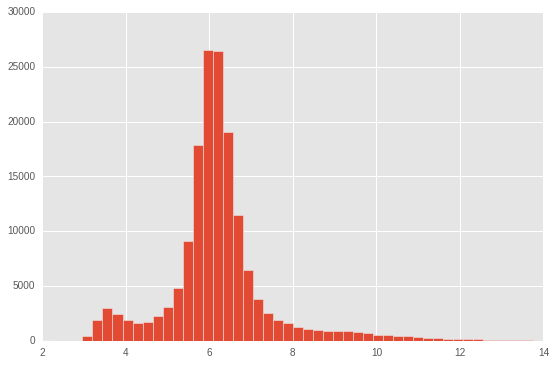

In [173]:
plt.hist(all_traj_features_conc.loc[all_traj_features_conc["Lig1-C9 to Gln124"] < 5.]["PHE289 to TYR336"].values, bins=50, range=[2.,14.])

(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.30000000e+01,   8.88000000e+02,   3.80500000e+03,
          5.31900000e+03,   4.93700000e+03,   4.07400000e+03,
          3.23900000e+03,   2.85000000e+03,   2.62400000e+03,
          2.86700000e+03,   3.40300000e+03,   5.10900000e+03,
          8.68600000e+03,   1.14120000e+04,   1.17230000e+04,
          8.71400000e+03,   5.50100000e+03,   3.44800000e+03,
          2.57000000e+03,   2.22900000e+03,   2.00900000e+03,
          1.90100000e+03,   1.60200000e+03,   1.19700000e+03,
          9.26000000e+02,   6.97000000e+02,   5.60000000e+02,
          4.64000000e+02,   4.58000000e+02,   4.31000000e+02,
          4.75000000e+02,   5.70000000e+02,   7.02000000e+02,
          7.78000000e+02,   7.40000000e+02,   7.26000000e+02,
          6.45000000e+02,   5.31000000e+02,   4.28000000e+02,
          3.72000000e+02,   2.77000000e+02,   1.78000000e+02,
          1.13000000e+02,   7.20000000e+01,   4.30000000e+01,
        

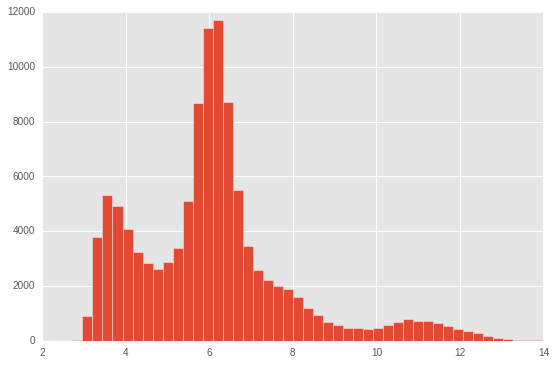

In [172]:
plt.hist(all_traj_features_conc.loc[all_traj_features_conc["Lig1-C9 to Gln124"] > 5.]["PHE289 to TYR336"].values, bins=50, range=[2,14])

In [ ]:
"%s/key_measurements_tIC5_3.png" %(analysis_dir)

In [ ]:
analysis_dir

In [91]:
projected_features = verboseload(projected_features_dir)
tica_resampled_file = os.path.join(tica_dir, "tica_msm_lag-time%d_clusters%d_resampled.h5" %(lag_time, n_clusters))
resample_features_by_msm_equilibirum_pop(projected_features, suf_pp_resampled_traj_to_frames, tica_resampled_file)
tica_resampled = verboseload(tica_resampled_file)
#plot_columns(tica_dir, tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_suf_BP_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/tica_msm_lag-time50_clusters1000_resampled.h5"... (<class 'numpy.ndarray'>)
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/tica_msm_lag-time50_clusters1000_resampled.h5"...


In [92]:
suf_pp_resampled_traj_index_pairs = []
for traj in suf_pp_resampled_traj_to_frames.keys():
    [suf_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in suf_pp_resampled_traj_to_frames[traj]]

apo_pp_resampled_traj_index_pairs = []
for traj in apo_pp_resampled_traj_to_frames.keys():
    [apo_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in apo_pp_resampled_traj_to_frames[traj]]

def create_features_eq_df(resampled_traj_index_pairs, feature_dfs, protein_top_features, ligand_top_features, pp_tica_resampled, ligand_tica_resampled, pp_pnas):
    all_dfs = []
    pp_features_eq = resample_features_by_msm_trajectory(protein_top_features, resampled_traj_index_pairs)
    all_dfs.append(pp_features_eq)
    if ligand_top_features is not None:
        ligand_features_eq = resample_features_by_msm_trajectory(ligand_top_features, resampled_traj_index_pairs)
        all_dfs.append(ligand_features_eq)
    pp_tica_eq = pd.DataFrame(pp_tica_resampled, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)])
    all_dfs.append(pp_tica_eq)
    if ligand_tica_resampled is not None:
        ligand_tica_eq = pd.DataFrame(ligand_tica_resampled, columns=["suf tIC.%d" %i for i in range(1,n_components+1)])
        all_dfs.append(ligand_tica_eq)
    pnas_eq = pd.DataFrame(pp_pnas, columns=sorted(feature_name_residues_dict.keys()))
    all_dfs.append(pnas_eq)
    features_eq = pd.concat(all_dfs, axis=1)
    features_eq.columns = [str(f) for f in features_eq.columns.values.tolist()]
    return features_eq

features_eq = create_features_eq_df(suf_pp_resampled_traj_index_pairs, suf_feature_dfs, protein_top_features_suf, suf_feature_dfs, suf_pp_tica, tica_resampled, suf_pp_pnas)
apo_features_eq = create_features_eq_df(apo_pp_resampled_traj_index_pairs, None, protein_top_features_apo, None, apo_pp_tica, None, apo_pp_pnas)

In [ ]:
import sklearn
lig_names = suf_feature_dfs[0].columns.values.tolist()
a = features_eq[lig_names].values
print(a.shape)
b = features_eq[aromatic_names].values / 10.
print(b.shape)
x = np.nan_to_num(np.hstack([a, b]))
pm = compute_pearson_matrix(x, features_eq[["tm6_tm3_packing", "PHE289 to ASN150"]].values)
print(x.shape)
pmdf = pd.DataFrame(pm, columns=["a" , "b"], index=(lig_names+aromatic_names))
pmdf["b"].loc[[n for n in pmdf.index.values.tolist() if "trp" in n.lower() or "tyr" in n.lower() or "phe" in n.lower() or "his" in n.lower()]].dropna().sort(ascending=False,inplace=False)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
#activating_features = ["LIG-C19 to TRP318-CG: Pi T", "LIG-C19 to TRP318-CD2: Pi T", "LIG-C22 to HIS297-ND1: Pi T", "LIG-C19 to TYR326-CG: Pi T", "LIG-C19 to TYR326-CG: Pi Parallel", "LIG-C19 to HIS297-ND1: Pi T"]
activating_features = ["LIG-C19 to TRP318-CG: Pi T", "LIG-C19 to TRP318-CD2: Pi T"]
data_indices = []
for f in activating_features:
    data_indices += features_eq.loc[features_eq[f] == 10].index.values.tolist()
data = features_eq.iloc[list(set(data_indices))]["PHE289 to ASN150"]
#data = features_eq.loc[(features_eq['LIG-C19 to TRP318-CG: Pi T'] == 10) | (features_eq['LIG-C19 to TRP318-CD2: Pi T'] == 10)]["PHE289 to ASN150"].values
print(data.shape)
#data = features_eq.loc[(features_eq['TRP293-CD2 to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CD2 to PHE289-CG, Pi Parallel'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi Parallel'] == 0)]["tm6_tm3_packing"].values
title = "Activating Features" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s_7A.pdf" %(analysis_dir, title, xlabel)
custom_bounds = [features_eq["tm6_tm3_packing"].min(), features_eq["tm6_tm3_packing"].max()]
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])

In [ ]:
data = features_eq.loc[(features_eq['LIG-C19 to TRP318-CG: Pi T'] == 0) & (features_eq['LIG-C19 to TRP318-CD2: Pi T'] == 0)]["PHE289 to ASN150"].values
print(data.shape)
#data = features_eq.loc[(features_eq['TRP293-CD2 to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CD2 to PHE289-CG, Pi Parallel'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi Parallel'] == 0)]["tm6_tm3_packing"].values
title = "SUF to TRP318: Not Pi T" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s_7A.pdf" %(analysis_dir, title, xlabel)
custom_bounds = [features_eq["tm6_tm3_packing"].min(), features_eq["tm6_tm3_packing"].max()]
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])

In [ ]:
data = features_eq.loc[(features_eq['LIG-C22 to TRP293-CD2: Pi T'] == 0) & (features_eq['LIG-C22 to TRP293-CG: Pi T'] == 0)]["PHE289 to ASN150"].values
print(data.shape)
#data = features_eq.loc[(features_eq['TRP293-CD2 to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CD2 to PHE289-CG, Pi Parallel'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi Parallel'] == 0)]["tm6_tm3_packing"].values
title = "SUF to TRP293: Not Pi T" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s_7A.pdf" %(analysis_dir, title, xlabel)
custom_bounds = [features_eq["tm6_tm3_packing"].min(), features_eq["tm6_tm3_packing"].max()]
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])

In [ ]:
features_eq.columns.values.tolist()

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

In [ ]:
data = features_eq.loc[(features_eq['LIG-C22 to TRP293-CD2: Pi T'] == 10) | (features_eq['LIG-C22 to TRP293-CG: Pi T'] == 10)]["PHE289 to ASN150"].values
print(data.shape)
#data = features_eq.loc[(features_eq['TRP293-CD2 to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CD2 to PHE289-CG, Pi Parallel'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi Parallel'] == 0)]["tm6_tm3_packing"].values
title = "SUF to TRP293: Pi T" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s.pdf" %(analysis_dir, title, xlabel)
custom_bounds = [features_eq["tm6_tm3_packing"].min(), features_eq["tm6_tm3_packing"].max()]
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])

In [ ]:
title = "Sufentanil and Tyr326 Pi Parallel" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s.pdf" %(analysis_dir, title, xlabel)
data = features_eq.loc[(features_eq['LIG-C22 to TYR326-CG: Pi Parallel'] == 10)]["PHE289 to ASN150"].values
print(data.shape)
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])
plt.show()

In [ ]:
title = "Sufentanil and Tyr326 Not Pi Parallel" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s.pdf" %(analysis_dir, title, xlabel)
data = features_eq.loc[(features_eq['LIG-C22 to TYR326-CG: Pi Parallel'] == 0)]["PHE289 to ASN150"].values
print(data.shape)
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])
plt.show()

In [ ]:
title = "Sufentanil and Trp318 Not Pi T" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s_2.pdf" %(analysis_dir, title, xlabel)
data = features_eq.loc[(features_eq['LIG-C19 to TRP318-CG: Pi T'] == 0) & (features_eq['LIG-C19 to TRP318-CD2: Pi T'] == 0)]["PHE289 to ASN150"].values
print(data.shape)
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])
plt.show()

In [ ]:
title = "Sufentanil and Trp133 Pi T" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s_2.pdf" %(analysis_dir, title, xlabel)
data = features_eq.loc[(features_eq['LIG-C19 to TRP133-CG: Pi Parallel'] == 1) | (features_eq['LIG-C19 to TRP133-CD2: Pi T'] == 1)]["PHE289 to ASN150"].values
print(data.shape)
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])
plt.show()

In [ ]:
data.shape

In [ ]:
#pm = compute_pearson_matrix(features_eq["tm6_tm3_packing"].values.reshape((-1,1)), features_eq.values).reshape((-1,1))
titles_i = ["tm6_tm3_packing"] + pp_tica_eq.columns.values.tolist() + list(set(pp_features_eq.columns.values.tolist()))
titles_j = list(set(suf_features_eq.columns.values.tolist())) + suf_tica_eq.columns.values.tolist()
pm = compute_pearson_matrix(features_eq[titles_i].values, features_eq[titles_j].values)
pmdf = pd.DataFrame(pm, index=titles_i, columns=titles_j)

In [ ]:
pmdf.loc["tm6_tm3_packing"].sort(inplace=False)

In [ ]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [ ]:
plt.hexbin(features_eq["Lig900-N1 to Tyr326"], features_eq["tm6_tm3_packing"])

In [ ]:
pmdf.loc[[str(f) for f in suf_features_eq.columns.values.tolist()]].abs().sort("correlation", ascending=False,inplace=False).iloc[:50].plot(kind='barh')

In [ ]:
import seaborn as sns
from scipy.stats import kendalltau
def hexbin(x, y, color, gridsize=25, n_colors=10, **kwargs):
    cmap = sns.light_palette(color, n_colors=n_colors, as_cmap=True)
    #cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=gridsize, cmap=cmap, **kwargs)
    
g = sns.PairGrid(features_eq[["tm6_tm3_packing", "rmsd_npxxy_inactive", "mOR tIC.4", "mOR tIC.6", "(MET281_CA, MET161_CA)", "(Lig900-C19, Gln124)", "(Lig900-C16, Val300)", "(Lig900-C8, Met151)", "(Lig900-N1, Tyr326)"]])# "(GLY82, TYR326)", "(TYR326, ASP147)", "suf tIC.3", "(Lig900-N1, Tyr326)", "(Lig900-C4, Tyr326)", "(Lig900-C20, Gln124)", "(Lig900-C6, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(plt.scatter, s=0.1, color="purple")
g.map_lower(plt.scatter, s=0.1, color="purple")

In [ ]:
def custom_lim_finder(values):
    mins = np.min(values, axis=0)
    maxs = np.max(values, axis=0)
    stds = np.std(values, axis=0)
    custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
    return custom_lims

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
#titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in suf_pp_tIC_features[1]][:5] + ["suf tIC.3"] + [str(f) for f in all_tIC_features[2]][:5]
titles_i = ["tm6_tm3_packing"] + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + ["suf tIC.%d" %i for i in range(1,n_components+1)]
features_eq_vals = features_eq[titles_i].values
mins = np.min(features_eq_vals, axis=0)
maxs = np.max(features_eq_vals, axis=0)
stds = np.std(features_eq_vals, axis=0)
custom_lims = [[mins[i] - 0.5*stds[i], maxs[i] + 0.5*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq_vals, analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15, worker_pool=None, parallel=True)

In [ ]:
from jointplot_d3 import *
titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in suf_pp_tIC_features[1]] + ["mOR tIC.3"] + [str(f) for f in all_tIC_features[2]]
tica_resampled = np.vstack([verboseload(suf_pnas_resampled_file)[::1,], verboseload(apo_pnas_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq[titles_i], analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15)

In [ ]:
all_tIC_features[0]

In [ ]:
"""
['suf_reimaged_rep_100.h5', 'suf_reimaged_rep_119.h5', 'suf_reimaged_rep_179.h5', 'suf_reimaged_rep_184.h5', 'suf_reimaged_rep_186.h5', 'suf_reimaged_rep_24.h5', 'suf_reimaged_rep_255.h5', 'suf_reimaged_rep_27.h5', 'suf_reimaged_rep_56.h5', 'suf_reimaged_rep_58.h5', 'suf_reimaged_rep_59.h5', 'suf_reimaged_rep_63.h5', 'suf_reimaged_rep_64.h5', 'suf_reimaged_rep_83.h5', 'suf_rep_139.h5', 'suf_rep_84.h5']"""
suf_traj_names = [os.path.basename(t) for t in trajs if "suf" in t]
traj_idx = suf_traj_names.index('suf_rep_139.h5')
f = all_traj_features[traj_idx][["tm6_tm3_packing", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]]
#f = protein_ligand_msm_featurized[f.columns.values]
pd.rolling_mean(f[f.columns.values[0]], window=50).plot()

In [ ]:
pd.rolling_mean(f[f.columns.values[1]], window=50).plot()

In [ ]:
pmdf.index.values

In [ ]:
suf_pp_pnas.T[1,:].shape

In [ ]:
from pandas.tools.plotting import scatter_matrix
#df = pd.concat([pp_features_eq, suf_features_eq], axis=1)[["(MET281_CA, MET161_CA)", "(Lig900-N1, Tyr326)"] + [str(f) for f in suf_pp_tIC_features[2][:2] +  all_tIC_features[2][:2]]]
df = features_eq[all_features[0]]
sm = scatter_matrix(df.iloc[::100], figsize=(6, 6), diagonal='kde')
[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
plt.show()

In [ ]:
import seaborn as sns



g = sns.PairGrid(features_eq[all_features[0]])
g.map_upper(sns.jointplot, kind="hex", stat_func=kendalltau, color="#4CB391")
#cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
#g.map_lower(sns.kdeplot, cmap="Blues_d", n_levels=5, shade=True, shade_lowest=False)
#g.map_diag(sns.kdeplot)
#g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)

In [ ]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
keep_steps = 100000
subsample = 100
ligand_msm_featurized_traj = resample_features_by_msm_trajectory(ligand_top_features, msm_traj_index_pairs[0:keep_steps])
protein_msm_featurized_traj = resample_features_by_msm_trajectory(protein_top_features_suf, msm_traj_index_pairs[0:keep_steps])
protein_msm_tica_traj = resample_features_by_msm_trajectory(suf_tica_dfs, msm_traj_index_pairs[0:keep_steps])
protein_msm_pnas_traj = resample_features_by_msm_trajectory(suf_pnas_dfs, msm_traj_index_pairs[0:keep_steps])
suf_msm_tica_traj = resample_features_by_msm_trajectory(tica_dfs, msm_traj_index_pairs[0:keep_steps])


protein_ligand_msm_featurized = pd.concat([ligand_msm_featurized_traj, protein_msm_featurized_traj, protein_msm_tica_traj, protein_msm_pnas_traj, suf_msm_tica_traj], axis=1)
plmf = protein_ligand_msm_featurized.iloc[::10]

In [ ]:
plt.scatter(pd.concat(all_traj_features, axis=0)["Lig1-N1 to Tyr326"].iloc[::100], pd.concat(all_traj_features, axis=0)["PHE289 to ASN150"].iloc[::100])
plt.show()

In [ ]:
features_eq.loc[(features_eq["TRP293-CD2 to PHE289-CG: Pi Parallel"] == 1) | (features_eq["TRP293-CD2 to PHE289-CG: Pi T"] == 1) | (features_eq["TRP293-CG to PHE289-CG: Pi Parallel"] == 1) | (features_eq["TRP293-CG to PHE289-CG: Pi T"] == 1)].shape

In [ ]:
apo_features_eq.loc[(features_eq["TRP293-CD2 to PHE289-CG: Pi Parallel"] == 1) | (features_eq["TRP293-CD2 to PHE289-CG: Pi T"] == 1) | (features_eq["TRP293-CG to PHE289-CG: Pi Parallel"] == 1) | (features_eq["TRP293-CG to PHE289-CG: Pi T"] == 1)].shape

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
intermediates = cluster_features_averages.loc[(cluster_features_averages["LIG-C19 TO TRP133-CD2: PI T"] > 0.5) & (cluster_features_averages["PHE289 to ASN150"] > 10.)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["PHE289 to ASN150"] > 10.) & (cluster_features_averages["PHE289 to ASN150"] < 12.)].index.values
counts = [len(suf_pp_clusters_map[i]) for i in range(0, pp_n_clusters)]
for c in np.argsort(-1.0*np.array(counts)):
    if c in intermediates:
        print(c)
#intermediates = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 13.) & (cluster_features_averages["PHE289 to ASN150"] > 16.) & (cluster_features_averages["TYR336 to PHE289"] > 12.)].index.values# & (cluster_features_averages["Lig1-C9 to Trp318"] < 6.)].index.values
print(intermediates)
find_most_populated_intermediates(suf_pp_msm, intermediates)

In [ ]:

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 0.) & (cluster_features_averages["TYR336 to PHE289"] > 9.)].index.values
msm_intermediate_actives = np.concatenate(suf_pp_msm.partial_transform(intermediate_actives))
order = np.argsort(suf_pp_msm.populations_[msm_intermediate_actives])
print(np.sum(suf_pp_msm.populations_[msm_intermediate_actives][order]))
print(intermediate_actives[order])

In [ ]:
plt.hist(features_eq["TYR336 to PHE289"], bins=100)
plt.show()

In [ ]:
clus

In [ ]:
plt.clf()
plt.hist(cluster_features_averages["tm6_tm3_packing"].dropna().values, bins=50)
plt.show()

In [ ]:
[n for n in features_eq.columns.values.tolist() if "318" in n]

In [ ]:
plt.clf()
plt.hist(features_eq['Lig1-O2 to Trp318'], bins=50)
plt.show()

In [ ]:
suf_msm.inverse_transform(np.argsort(-1.*suf_msm.populations_))

In [ ]:
suf_msm.populations_[np.argsort(suf_msm.populations_)]

In [ ]:

all_traj_features_np = [f.values for f in all_traj_features_apo]

cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.)].index.values
msm_intermediate_actives = np.concatenate(apo_pp_msm.partial_transform(intermediate_actives))
order = np.argsort(apo_pp_msm.populations_[msm_intermediate_actives])
print(np.sum(apo_pp_msm.populations_[msm_intermediate_actives][order]))
print(intermediate_actives[order])

tpt_paths_features = []
for tpt_path in inv_tpt_paths:
    tpt_paths_features.append(cluster_features_averages.iloc[tpt_path])

In [ ]:
all_traj_features_np[3]

In [ ]:
prot_features = list(set([str(g) for l in suf_pp_tIC_features for g in l]))
f1 = pd.concat([f*10. for f in protein_top_features_apo], axis=0)
f2 = pd.concat([f for f in apo_tica_dfs])
f3 = pd.concat([f for f in apo_pnas_dfs])
prot_lig_features = pd.concat([f1,f2,f3],axis=1)
all_traj_features_apo = [pd.concat([protein_top_features_apo[i]*10., apo_tica_dfs[i], apo_pnas_dfs[i]], axis=1) for i in range(0, len(apo_tica_dfs))]



all_traj_features_np = [f.values for f in all_traj_features_apo]
cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["ASP114 to TYR336"] > 11.) & (cluster_features_averages["tm6_tm3_packing"] > 12.)].index.values
msm_intermediate_actives = apo_pp_msm.partial_transform(intermediate_actives)[0]


order = np.argsort(suf_pp_msm.populations_[msm_intermediate_actives])
print(suf_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])

In [ ]:

pp_feature_names = protein_top_features[0].columns.values.tolist() + sorted(feature_name_residues_dict.keys()) + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + [n for n in aromatic_names if "lig" not in n.lower()]
lp_feature_names = [str(f) for f in new_feature_names]

#y = features_eq[protein_top_features[0].columns.values.tolist() + sorted(feature_name_residues_dict.keys()) + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + [n for n in aromatic_names if "lig" not in n.lower()]]
#x = features_eq[[str(f) for f in new_feature_names]]

all_pp_features_onehot, pp_names_onehot = multi_onehot_trajectories([t[pp_feature_names].values[::100] for t in all_traj_features] + [features_eq[pp_feature_names].values], pp_feature_names, subsample=1)
all_lp_features_onehot, lp_names_onehot = multi_onehot_trajectories([t[lp_feature_names].values[::100] for t in all_traj_features] + [features_eq[lp_feature_names].values], lp_feature_names, custom_bounds=[5.0], subsample=1)

all_pp_features_onehot = [pd.DataFrame(t, columns=pp_names_onehot) for t in all_pp_features_onehot]
all_lp_features_onehot = [pd.DataFrame(t, columns=lp_names_onehot) for t in all_lp_features_onehot]

#if not os.path.exists("%s/all_features_multionehot_logistic_scores.h5" %analysis_dir):
data_i = pd.concat(all_lp_features_onehot, axis=0).values
data_j = pd.concat(all_pp_features_onehot, axis=0).values
onehot_scores, onehot_importances = compute_sl_matrix(data_i, data_j, n_trees=500, n_folds=5, max_depth=3, task="classification", model_type="logistic")
verbosedump(onehot_scores, "%s/all_features_multionehot_classified_logistic_scores.h5" %analysis_dir)
verbosedump(onehot_importances, "%s/all_features_multionehot_classified_logistic_importances.h5" %analysis_dir)
#else:
#    scores = verboseload("%s/all_features_multionehot_classified_logistic_scores.h5" %analysis_dir)
#    importances = verboseload("%s/all_features_multionehot_classified_logistic_importances.h5" %analysis_dir)



In [ ]:
all_pp_features_onehot, pp_names_onehot = multi_onehot_trajectories([features_eq[pp_feature_names].values], pp_feature_names, subsample=1)

In [ ]:
[n for n in pp_names_onehot if "PHE289 to ASN150" in n]

In [ ]:
plt.hist(np.concatenate([t["TYR336 to ASP114"].values for t in all_traj_features]), bins=50)
plt.show()

In [ ]:
plt.hist(features_eq["PHE289 to ASN150"].values, bins=200)
plt.show()

In [ ]:
#### auc_scores_df = pd.Series(onehot_scores, index=pp_names_onehot).sort(ascending=False, inplace=False)
auc_scores_df = auc_scores_df.iloc[:50]
title = "Predicting Protein Conformation by Ligand Orientation"
auc_scores_df.plot(kind='barh', title=title, figsize=(5,10))
plt.xlabel("Average Test ROC AUC")
plt.ylabel("Protein Feature")
plt.savefig("%s/all_features_oneshot_%s.pdf" %(analysis_dir, title))
plt.show()

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

importances_df = pd.DataFrame(onehot_importances, columns=pp_names_onehot, index=lp_names_onehot)
protein_features = ["PHE289 to ASN150", "tm6_tm3_packing", "MET281_CA to MET161_CA", "TYR336 to PHE289", "HIS319 to TYR75"]
plot_lp_pp_model_outcomes(importances_df, onehot_scores, analysis_dir, pd.concat(all_traj_features, axis=0), n_pp_features=25,
                                  n_lp_features=50, protein_features=protein_features, ref_features_df=ref_features)

In [ ]:
tpt_paths_features[6]["Lig900-N1 to Tyr326"]

In [ ]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 9.5) & (cluster_features_averages["(PHE156, SER196)"] < 10.5)].index)
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 6.) & (cluster_features_averages["(PHE156, SER196)"] < 7.)].index)

In [ ]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 11.) & (cluster_features_averages["(ASP114, TYR336)"] > 8.)& (cluster_features_averages["(Lig900-C19, Ile322)"] > 5.)].index)

In [ ]:
plt.hist(features_eq["Lig900-N1 to Tyr326"], bins=200)
plt.show()

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["mOR tIC.6"] > 4.)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 10.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 13.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(VAL89_CA, TYR336_CA)"] >11.5)].index

In [ ]:
g = sns.PairGrid(prot_lig_features[["tm6_tm3_packing", "tIC.3", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(hexbin, color="purple", n_colors=30, gridsize=30)
g.map_lower(plt.scatter, s=.1)

In [ ]:
protein_top_features[0].iloc[::3]

In [ ]:
import seaborn as sns

In [ ]:
pmdf

In [ ]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [ ]:
prot_lig_features.plot(kind='scatter', x="(MET281_CA, MET161_CA)", y= "(Lig900-C10, Val236)")

In [ ]:
plmf.columns.values

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
    r2_scores, importances = compute_rf_matrix(tica_resampled, suf_pp_tica, n_trees=500, n_folds=10)
    verbosedump(r2_scores, "%s/rfr_r2_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/rfr_importances.h5" %analysis_dir)
else:
    r2_scores = verboseload("%s/rfr_r2_scores.h5" %analysis_dir)
    importances = verboseload("%s/rfr_importances.h5" %analysis_dir)

In [ ]:
r2_scores_df = pd.Series(r2_scores, index=["mOR tIC.%d" %i for i in range(1, len(r2_scores)+1)])
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title)
plt.xlabel("RFR Test R^2")
plt.ylabel("Protein tIC")
plt.savefig("%s/%s.pdf" %(analysis_dir, title))
plt.show()

In [ ]:
plt.scatter(features_eq["mOR tIC.10"].iloc[::10], features_eq["tm6_tm3_packing"].iloc[::10])
plt.show()

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
#if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
#pd.concat([pp_features_eq, suf_features_eq, pp_tica_eq, suf_tica_eq, suf_pnas_eq], axis=1)
#y = pd.concat([pp_tica_eq, suf_pnas_eq["tm6_tm3_packing", "rmsd_npxxy_active"]], axis=1)
y = features_eq[["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]]

#y = features_eq[protein_top_features[0].columns.values.tolist() + sorted(feature_name_residues_dict.keys()) + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + [n for n in aromatic_names if "lig" not in n.lower()]]
#x = features_eq[[str(f) for f in new_feature_names]]
x = features_eq[[str(n) for n in all_ligand_feature_names] + ["suf tIC.%d" %i for i in range(1, n_components+1)]]

#if not os.path.exists("%s/all_features_rfc_scores.h5" %analysis_dir):
    #print("hi")
scores, importances = compute_rf_matrix(x.values, y.values, n_trees=500, n_folds=10)
verbosedump(scores, "%s/all_features_rfc_scores.h5" %analysis_dir)
verbosedump(importances, "%s/all_features_rfc_importances.h5" %analysis_dir)
#else:
#    scores = verboseload("%s/all_features_rfc_scores.h5" %analysis_dir)
#    importances = verboseload("%s/all_features_rfc_importances.h5" %analysis_dir)

In [ ]:
features_eq["Lig1-C23 to Ala240"]

In [ ]:
r2_scores_df = pd.Series(scores, index=y.columns)
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title)
plt.xlabel("RFR Test R^2")
plt.ylabel("Protein Feature")
plt.show()
plt.savefig("%s/all_features_%s.pdf" %(analysis_dir, title))

In [ ]:


#if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
#pd.concat([pp_features_eq, suf_features_eq, pp_tica_eq, suf_tica_eq, suf_pnas_eq], axis=1)
#y = pd.concat([pp_tica_eq, suf_pnas_eq["tm6_tm3_packing", "rmsd_npxxy_active"]], axis=1)

y = features_eq[protein_top_features[0].columns.values.tolist() + sorted(feature_name_residues_dict.keys()) + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + [n for n in aromatic_names if "lig" not in n.lower()]]
x = sklearn.preprocessing.binarize(features_eq[[str(f) for f in new_feature_names]].values, 5.)
x = np.hstack([x, features_eq[[n for n in aromatic_names if "lig" in n.lower()]].values])
x = pd.DataFrame(x, columns = [str(f) for f in new_feature_names] + [n for n in aromatic_names if "lig" in n.lower()])
#x = features_eq[ligand_top_features[0].columns.values.tolist() + [n for n in aromatic_names if "lig" in n.lower()]]

#y_classified = copy.deepcopy(y.values)
#for j in range(0, y.values.shape[1]):
#    try:
#        minima = get_kde_mins(y.values[:,j])
#        y_classified[:,j] = multi_binarizer(y.values[:,j], minima)
#    except:
#        continue
#y_classified = pd.DataFrame(y_classified, columns = y.columns)



In [ ]:
analysis_dir

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

In [ ]:
if not os.path.exists("%s/all_features_classified_rfc_scores.h5" %analysis_dir):
    scores, importances = compute_rf_matrix(x.values, y_classified.values, n_trees=500, max_depth=3, n_folds=10, task="classification")
    verbosedump(scores, "%s/all_features_classified_rfc_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/all_features_classified_rfc_importances.h5" %analysis_dir)
else:
    scores = verboseload("%s/all_features_classified_rfc_scores.h5" %analysis_dir)
    importances = verboseload("%s/all_features_classified_rfc_importances.h5" %analysis_dir)

#if not os.path.exists("%s/all_features_rfr_r2_scores.h5" %analysis_dir):
#    print("hi")
#r2_scores, importances = compute_rf_matrix(x.values, y.values, n_trees=500, n_folds=10)
#verbosedump(r2_scores, "%s/all_features_rfr_r2_scores.h5" %analysis_dir)
#verbosedump(importances, "%s/all_features_rfr_importances.h5" %analysis_dir)
#else:
#r2_scores = verboseload("%s/all_features_rfr_r2_scores.h5" %analysis_dir)
#importances = verboseload("%s/all_features_rfr_importances.h5" %analysis_dir)

In [ ]:
list(set(x['LIG-N4 to HIS297-ND1: Cation-Pi'].values.tolist()))

In [ ]:
y["PHE289 to ASN150"].loc[x['LIG-C22 to TYR326-CG: Pi Parallel']==10].shape

In [ ]:
plt.clf()
plt.hist(y["PHE289 to ASN150"].loc[x['LIG-C22 to TYR326-CG: Pi Parallel']==10], bins=50,range=[5,16])
plt.show()

In [ ]:
plt.clf()
plt.hist(y["PHE289 to ASN150"].loc[x['LIG-C22 to TYR326-CG: Pi Parallel']==0].values, bins=50, range=[5,16])
plt.show()

In [ ]:
print(importances.shape)
print(y.shape)
print(x.shape)

In [ ]:
plt.show()

In [ ]:
scores_df = pd.Series(scores, index=y.columns)
scores_df.sort(inplace=False)

In [ ]:
#pearson_matrix = compute_pearson_matrix(x.values, y.values)
#pearson_df = pd.DataFrame(pearson_matrix, columns=y.columns, index=x.columns)
pearson_df["tm6_tm3_packing"].abs().sort(inplace=False)

In [ ]:
importances_df = pd.DataFrame(importances, columns=y.columns, index=x.columns)
#importances_df["mOR tIC.5"].loc[[n for n in importances_df.index.values.tolist()]].abs().sort(inplace=False, ascending=False)
importances_df["PHE289 to ASN150"].abs().sort(inplace=False, ascending=False).iloc[:100]


In [ ]:
analysis_dir

In [ ]:
#import matplotlib
#matplotlib.style.use('ggplot')
#from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from plots import *
sc = StandardScaler()

#importances_scaled = pearson_matrix.T
#importances_scaled = sc.fit_transform(importances)
importances_scaled = copy.deepcopy(importances)
#for j in range(0, importances_scaled.shape[1]):
#    importances_scaled[:,j] *= r2_scores[j]

#responses_to_keep = np.where(np.array(r2_scores) > 0.5)[0]
#importances_scaled = importances_scaled[:,responses_to_keep]
#predictors_to_keep = list(set(np.where(importances_scaled > 0.03)[0].tolist()))
#print(responses_to_keep)
#print(predictors_to_keep)
#importances_scaled = importances_scaled[predictors_to_keep,:]
#print(len(responses_to_keep))

row_labels = ["suf tIC.%d" %i for i in range(1, n_components+1)]
column_labels = ["mOR tIC.%d" %i for i in range(1, pp_n_components+1)]
#row_labels = x.columns.values[predictors_to_keep]
#column_labels = y.columns.values[responses_to_keep]

importance_df = pd.DataFrame(importances_scaled, columns=column_labels, index=row_labels)

plot_clustermap(importance_df, save_file="%s/all_features_rfr_feature_importances.pdf" %(analysis_dir), method='average', row_cluster=False, col_cluster=False, z_score=None, xtick_labelsize=8, ytick_labelsize=8)
plt.show()

"""

plot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method='average', z_score=None)



fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)

# want a more natural, table-like display
#ax.invert_yaxis()
#ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False, rotation=270)
ax.set_yticklabels(column_labels, minor=False)
fig.subplots_adjust(bottom=0.2)

fig.savefig("%s/suf_vs_pp_pearson_heatmap.svg" % analysis_dir, format='svg', dpi=1200)
plot_file = "%s/suf_vs_pp_pearson_heatmap.pdf" % analysis_dir
pp = PdfPages(plot_file)

pp.savefig(fig)

pp.close()  
plt.show()
"""

In [ ]:
from jointplot_d3 import *
titles_j = [f for f in features_eq.columns.values if "Lig" in f and "Tyr326" in f]
print(titles_j)
jointplots(features_eq[titles_j].values, analysis_dir, titles=titles_j,
                           main = "mOR MSM", refcoords=None, refcoords_j=None, axes=None,
                               data_j=features_eq[["tm6_tm3_packing"]].values, titles_j=["tm6_tm3_packing"], reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    

r2_scores

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=2, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    suf_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(suf_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            #if prot_idx != 9: continue
            print(lig_order)
            for l, lig_idx in enumerate(lig_order):
                if l == n_lig_tICs:
                    break
            
                features = []

                print("mOR tIC.%d" %(k+1))
                prot_features = ["mOR tIC.%d" %(prot_idx+1)]
                if custom_features is not None:
                    prot_features += custom_features[0]
                lig_features = ["suf tIC.%d" %(lig_idx+1)]
                all_prot_features = [str(f) for f in top_features_per_tIC_i[prot_idx]]
                all_lig_features = [str(f) for f in top_features_per_tIC_j[lig_idx]]
                pearson_matrix = compute_pearson_matrix(plmf[all_prot_features].values, plmf[all_lig_features].values)
                pearson_shape = pearson_matrix.shape
                inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(pearson_matrix).ravel()), pearson_shape))[0]
                prot_inds = []
                lig_inds = []

                for j, ind in enumerate([idx[0] for idx in inds]):
                    if len(prot_inds) == max_features: break
                    if ind in prot_inds: continue
                    prot_features.append(str(top_features_per_tIC_i[prot_idx][ind]))
                    prot_inds.append(ind)

                if custom_features is not None:
                    features += custom_features[0]

                for j, ind in enumerate([idx[1] for idx in inds]):
                    if len(lig_inds) == max_features: break
                    if ind in lig_inds: continue
                    lig_features.append(str(top_features_per_tIC_j[lig_idx][ind]))
                    lig_inds.append(ind)

                if make_jointplots:
                    print("Creating joint deltaG plots.")
                    data_i = features_eq[prot_features+all_prot_features].values
                    print(data_i.shape)
                    data_j = features_eq[lig_features+all_lig_features].values
                    print(data_j.shape)
                    tic_save_dir = "%s/mOR_tIC%d_vs_suf_tIC%d" %(save_dir, prot_idx+1, lig_idx+1)
                    if not os.path.exists(tic_save_dir):
                        os.makedirs(tic_save_dir)
                    #else:
                    #    continue
                    
                    
                    if ref_df is not None:
                        refcoords = ref_df[prot_features+all_prot_features].values
                        print(refcoords.shape)
                        refcoords_j = ref_df[lig_features+all_lig_features].values
                        print(refcoords_j.shape)
                    else:
                        refcoords = None
                        refcoords_j = None

                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                               data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                               main = "mOR MSM", refcoords=refcoords, axes=None,
                               data_j=None, titles_j=None, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_j, tic_save_dir, titles=lig_features+all_lig_features,
                           main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                               data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

                features += (prot_features + lig_features)
    
                #plot_df_rolling(plmf[features].iloc[::subsample], "%s/key_measurements_tIC%d.pdf" %(save_dir, prot_idx+1), True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)
                #plt.show()  
                all_features.append(features)
    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=5, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=None, save_dir=jointplots_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

In [ ]:
protein_ligand_msm_featurized.columns.values.tolist()

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, features_i, features_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=100, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    suf_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(suf_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            
            if "PHE289 to ASN150" not in str(features_i[prot_idx]): continue
            
            all_prot_features = [str(features_i[prot_idx])]
            all_lig_features = [str(features_j[lig_idx]) for lig_idx in lig_order[:n_lig_tICs]]
            

            features = []
            prot_features = []
            lig_features = []

            if make_jointplots:
                print("Creating joint deltaG plots.")
                data_i = features_eq[prot_features+all_prot_features].values
                print(data_i.shape)
                data_j = features_eq[lig_features+all_lig_features].values
                print(data_j.shape)

                if ref_df is not None:
                    refcoords = ref_df[prot_features+all_prot_features].values
                    print(refcoords.shape)
                    refcoords_j = ref_df[lig_features+all_lig_features].values
                    print(refcoords_j.shape)
                    combined_refcoords = np.hstack([refcoords, refcoords_j])
                    custom_refcoords = ref_df[custom_features[0]].values
                else:
                    refcoords = None
                    refcoords_j = None
                    combined_refcoords = None
                    custom_refcoords = None

                jointplots(data_i, save_dir, titles=prot_features+all_prot_features,
                       main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8, custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(data_j, save_dir, titles=lig_features + all_lig_features, 
                       main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                           data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(np.hstack([data_i, data_j]), save_dir, titles=prot_features+all_prot_features+lig_features+all_lig_features,
                       main = "mOR MSM", refcoords=combined_refcoords, refcoords_j=custom_refcoords, axes=None,
                           data_j=features_eq[custom_features[0]].values, titles_j=custom_features[0], reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      y.columns, x.columns, n_combs=5,
                                      r2s = np.array(scores), subsample=1, smoothing=100,
                                      n_tICs=20, max_features=1,
                                      #custom_features = None,
                                      custom_features=[[], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=None, save_dir=jointplots_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

In [ ]:
jointplots_dir

In [ ]:
names

In [ ]:
features_eq[ 'Lig1-C13 to Lys233']

In [ ]:
tpt_paths_features

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None):

    for t, prot_pair in enumerate(prot_pairs):
        if t == n_tICs:
            break
        #if prot_pair[1] != 4: continue
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j = None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = [1, 3]
prot_pairs = []
for i in range(0, len(tics_to_examine)):
    for j in range(i+1, len(tics_to_examine)):
        prot_pairs.append((tics_to_examine[i], tics_to_examine[j]))
        prot_pairs.append((tics_to_examine[j], tics_to_examine[i]))
print(prot_pairs)
    
make_msm_features_plots_single(importances, protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=None, save_dir=jointplots_dir,
                                      prot_pairs=prot_pairs)
                                      #tpt_paths=None)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None, alt_features_eq=None):

    for t, prot_pair in enumerate(prot_pairs):
        #if prot_pair[1] != 4: continue
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j =  None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        if alt_features_eq is not None:
            custom_lims = custom_lim_finder(np.vstack([features_eq[features_i].values, alt_features_eq[features_i].values]))
            custom_lims_j = custom_lim_finder(np.vstack([features_eq[features_j].values, alt_features_eq[features_j].values]))
        else:
            custom_lims = None
            custom_lims_j = None

        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=custom_lims, custom_lims_j=custom_lims_j,
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

apo_jointplots_refcoords_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

suf_jointplots_refcoords_dir = "%s/suf_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(suf_jointplots_refcoords_dir):
    os.makedirs(suf_jointplots_refcoords_dir)
    
apo_jointplots_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = range(1,10)
prot_pairs = []
for i in tics_to_examine:
    for j in tics_to_examine:
        if j < i:
            prot_pairs.append((i,j))
print(prot_pairs)

make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=suf_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=apo_features_eq)
                                      #tpt_paths=None)
"""
make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=apo_features_eq, ref_df=ref_features, save_dir=apo_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=features_eq)
                                      #tpt_paths=None)
"""
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "BU72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

In [ ]:
suf_jointplots_refcoords_dir

In [ ]:
protein_ligand_msm_featurized.columns.values

In [ ]:
features_eq[all_prot_features].values

In [ ]:
features_eq.columns

In [ ]:
suf_

In [ ]:
custom_features_4 = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "(HIS319, TYR75)", "suf tIC.4", "(Lig900-C7, Tyr75)", "(Lig900-C7, Trp293)"]
make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_4, title="Key Measurements: mOR tIC.4")


In [ ]:
custom_features_2 = ["mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]

make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_2, title="Key Measurements: mOR tIC.2")




In [ ]:
print(importances)

In [ ]:
all_traj_files

In [176]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
coords_bounds_dict = {"ASN150 to PHE289": [(6.0, 8.)]}
all_traj_files = get_trajectory_files(traj_dir, traj_ext)
trajs_to_watch = reaction_coordinate_sampler([all_traj_files[i] for i in suf_trajs], ".h5", [t.values for t in all_traj_features], 
                            all_traj_features[0].columns.values.tolist(), coords_bounds_dict, 
                            None)

Analyzing ASN150 to PHE289
{'ASN150 to PHE289': [(183, 'suf__rep_42.h5'), (186, 'suf__rep_47.h5'), (254, 'suf_reseeded_p_rep_269.h5'), (293, 'suf_reseeded_p_rep_308.h5'), (398, 'suf_reseeded_p_rep_413.h5'), (434, 'suf_reseeded_p_rep_449.h5'), (435, 'suf_reseeded_p_rep_450.h5'), (436, 'suf_reseeded_p_rep_451.h5'), (437, 'suf_reseeded_p_rep_452.h5'), (439, 'suf_reseeded_p_rep_454.h5'), (440, 'suf_reseeded_p_rep_455.h5'), (441, 'suf_reseeded_p_rep_456.h5'), (442, 'suf_reseeded_p_rep_457.h5'), (443, 'suf_reseeded_p_rep_458.h5'), (444, 'suf_reseeded_p_rep_459.h5'), (445, 'suf_reseeded_p_rep_460.h5'), (446, 'suf_reseeded_p_rep_461.h5'), (448, 'suf_reseeded_p_rep_463.h5'), (467, 'suf_reseeded_p_rep_482.h5'), (470, 'suf_reseeded_p_rep_485.h5'), (471, 'suf_reseeded_p_rep_486.h5'), (472, 'suf_reseeded_p_rep_487.h5'), (473, 'suf_reseeded_p_rep_488.h5'), (474, 'suf_reseeded_p_rep_489.h5'), (475, 'suf_reseeded_p_rep_490.h5'), (478, 'suf_reseeded_p_rep_493.h5'), (480, 'suf_reseeded_p_rep_495.h5'), (

(array([  1.00000000e+01,   4.00000000e+01,   1.27000000e+02,
          2.38000000e+02,   3.17000000e+02,   4.35000000e+02,
          6.68000000e+02,   1.15700000e+03,   1.62700000e+03,
          1.99900000e+03,   2.02300000e+03,   1.84200000e+03,
          1.85500000e+03,   2.02300000e+03,   2.36400000e+03,
          2.97500000e+03,   3.85000000e+03,   5.24300000e+03,
          6.64600000e+03,   8.26100000e+03,   1.03300000e+04,
          1.28890000e+04,   1.64600000e+04,   2.02580000e+04,
          2.41570000e+04,   2.64100000e+04,   2.60300000e+04,
          2.34370000e+04,   1.96900000e+04,   1.57150000e+04,
          1.16200000e+04,   7.87500000e+03,   4.89600000e+03,
          2.94100000e+03,   1.85600000e+03,   1.18200000e+03,
          8.41000000e+02,   5.13000000e+02,   3.33000000e+02,
          2.30000000e+02,   1.79000000e+02,   1.13000000e+02,
          1.07000000e+02,   7.20000000e+01,   6.20000000e+01,
          5.00000000e+01,   3.00000000e+01,   2.70000000e+01,
        

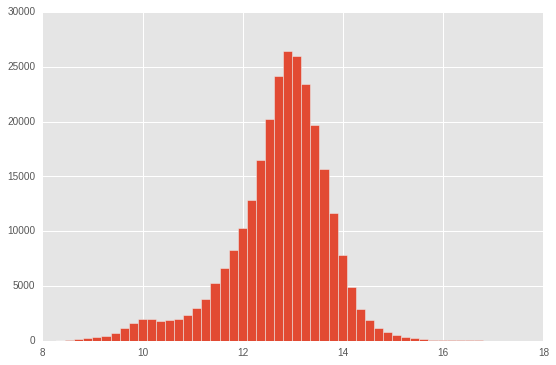

In [178]:
plt.hist(all_traj_features_conc["tm6_tm3_packing"], bins=50)

In [177]:
[t for t in trajs_to_watch["ASN150 to PHE289"] if "reseeded" not in t[1]]

[(183, 'suf__rep_42.h5'), (186, 'suf__rep_47.h5')]

we are operating on biox3


/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/detect_intermediates.py:486: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=True,window=10).mean()
  pd.rolling_mean(df, smoothing, center=True, min_periods=None)[var].plot(ax=axes[i], linewidth=2.5, title=var, c=c)


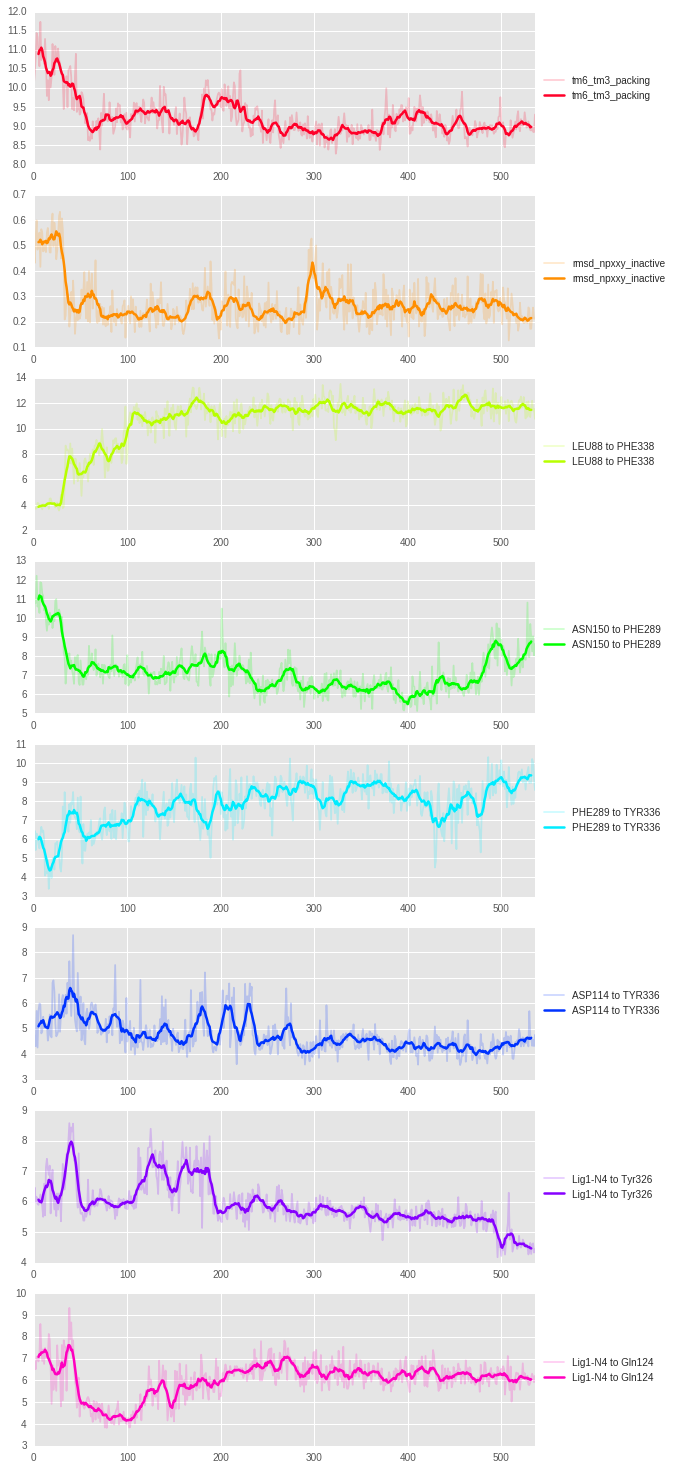

In [117]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
chosen_features = ["tm6_tm3_packing", "rmsd_npxxy_inactive", "LEU88 to PHE338", "ASN150 to PHE289", "PHE289 to TYR336", "ASP114 to TYR336", "Lig1-N4 to Tyr326", "Lig1-N4 to Gln124"]
for tup in [t for t in trajs_to_watch['ASN150 to PHE289']]:
    i = tup[0]
    name = tup[1]
    featurized_traj = all_traj_features[i]
    df = copy.deepcopy(featurized_traj[chosen_features])
    plot_df_rolling(df, "%s/SUF_%s.png" %(analysis_dir, name), return_fig=True, subplots=True, smoothing=10, include_original=True, min_periods=1, ref_df=None)

In [ ]:
test_df = pd.DataFrame(ref_features["Lig900-C21 to Tyr326"])
test_df = pd.concat([test_df.transpose()]*5)
test_df

In [ ]:
[f for f in all_traj_features[0].columns.values.tolist() if "Tyr326" in f]

In [ ]:
coords_bounds_dict = {"tm6_tm3_packing": [8.0, 10., 12.0, 16.0]}
trajs_to_watch = reaction_coordinate_sampler(traj_dir, ".h5",user_defined_coords, 
                            sorted(feature_name_residues_dict.keys()), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)
print([t for t in trajs_to_watch.values()[0] if "suf" in t])

In [ ]:
suf_pp_pnas.shape

In [ ]:
pearson_matrix

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "281_C" in name and "161_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "278_C" in name and "283_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "suf" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Tyr75" in name and "Lig900-C21" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Ile322" in name and "Lig900-C21" in name]

plot_df_rolling(protein_ligand_msm_featurized[feature0].iloc[::100], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=10, include_original=True, subplots=True, min_periods=None)
plt.show()

In [ ]:
plmf.columns.values

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name and "CA" not in name]
feature0 += ['(Phe338_Ca, Arg280_Ca)'.upper()]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.3" in name and "suf" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Gln124" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Gln124" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Tyr326" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Leu121" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Asn150" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "suf" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Tyr75" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Ile298" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-O1" in name and "Cys235" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Trp293" in name]

#2    Lig900-C7-Tyr75   Lig900-C7   Tyr75      900       75    0.740407   
###   Lig900-N1-Ile298   Lig900-N1  Ile298      900      298   -0.571373   
#1 # Lig900-O1-Cys235   Lig900-O1  Cys235      900      235    0.367512   
#3   Lig900-C7-Trp293   Lig900-C7  Trp293      900      293    0.286380   


plot_df_rolling(protein_ligand_msm_featurized[feature0], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=100, include_original=True, min_periods=None)
plt.show()

In [ ]:
protein_ligand_msm_featurized.columns.values

In [ ]:
'(Phe338_Ca, Arg280_Ca)'.upper()

In [ ]:
"%s/key_measurements.pdf" %analysis_dir

In [ ]:
import plots
reload(plots)
from plots import *
suf_pp_tica = verboseload("%s/suf_tica_msm_lag-time10_prior-counts0.0_clusters1000_resampled_10000.h5" %pp_tica_dir)
#plot_data_vs_data(tica_resampled, suf_pp_tica, ["suf-BP_tIC%d" %i for i in range(1,n_components+1)], ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)
#plot_data_vs_data(suf_pp_tica, tica_resampled, ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], ["suf-BP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(suf_pp_tica[::100,:], analysis_dir, titles = ["mOR_tIC%d" %i for i in range(1,n_components+1)], main = "mOR_vs_suf", refcoords_file = None, axes=None, reshape=True, data_j=tica_resampled[::100,:], titles_j=["suf_tIC%d" %i for i in range(1,n_components+1)])

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
MI_matrix = compute_MI_matrix(suf_pp_tica, tica_resampled)

In [ ]:
print(MI_matrix[3,:])
#print(MI_matrix[:,0])
rankings = np.zeros(np.shape(MI_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = MI_matrix.shape[0] + 1. - rankdata(MI_matrix[i,:], 'min')
rankings


In [ ]:
pearson_matrix

In [ ]:
np.max(np.abs(pearson_matrix), axis=0)

In [ ]:
plt.scatter(suf_pp_tica[:,5], tica_resampled[:,4])

In [ ]:
plt.scatter(suf_pp_tica[:,0], suf_pp_tica[:,5])

In [ ]:
importances

# import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

ks_matrix = compute_ks_matrix(suf_pp_tica, tica_resampled)
ks_matrix

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

#sr_matrix = compute_sr_matrix(suf_pp_tica, tica_resampled)
print(sr_matrix)

sr_matrix = np.abs(sr_matrix)
print(sr_matrix[0,:])
print(sr_matrix[3,:])
rankings = np.zeros(np.shape(sr_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = sr_matrix.shape[0] + 1. - rankdata(sr_matrix[i,:], 'min')
rankings



In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

rs_matrix = compute_rs_matrix(suf_pp_tica, tica_resampled)
print(rs_matrix)

rs_matrix = np.abs(rs_matrix)
print(rs_matrix[0,:])
print(rs_matrix[3,:])
rankings = np.zeros(np.shape(rs_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = rs_matrix.shape[0] + 1. - rankdata(rs_matrix[i,:], 'min')
rankings




In [ ]:
import entropy_estimators as ee

In [ ]:
tica_coords = verboseload(projected_features_dir)
np.shape(tica_coords[0])

In [ ]:
n_samples=10
save_dir = "%s/clusters100_samples10" % tica_dir
sampling_method = "random"
clusters_map_file = "%s/clusters100_map.h5" % tica_dir
sample_clusters(clusterer_dir, projected_features_dir, traj_dir, traj_ext, save_dir, n_samples, method = sampling_method, clusters_map_file = clusters_map_file)

In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_all_tics_and_clusters(tica_dir, projected_features_dir, clusterer_dir, lag_time, label = "cluster_id", active_cluster_ids = range(0,n_clusters), intermediate_cluster_ids = [], inactive_cluster_ids = [])

In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, list(range(1,25)))


In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = "%s/msm100_frames.h5" %tica_dir
msm_trajectory_filename = "%s/msm100_1000frames" %tica_dir
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=22, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters= 1500
samples_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree" %(pp_tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(pp_tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(apo_pp_clusterer_file, apo_pp_tica_file, [traj_files[i] for i in apo_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG")